# Encoder Decoder Networks for Cambridge UK Weather Time Series

Encoder decoder models for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

This notebook is being developed on [Google Colab](https://colab.research.google.com), primarily using [keras/tensorflow](https://www.tensorflow.org/guide/keras/sequential_model).  Initially I was most interested in short term temperature forecasts (less than 2 hours) but now mostly produce results up to 48 hours in the future for comparison with earlier [baselines](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb).

See my previous notebooks, web apps etc:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

The linked notebooks, web apps etc contain further details including:
 * data description
 * data cleaning and preparation
 * data exploration

In particular, see the notebooks:
 * [cammet_baselines_2021](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) including persistent, simple exponential smoothing, Holt Winter's exponential smoothing and vector autoregression
 * [keras_mlp_fcn_resnet_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
 * [lstm_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb) with stacked LSTMs, bidirectional LSTMs and ConvLSTM1D networks
 * [cnn_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cnn_time_series.ipynb) with Conv1D, multi-head Conv1D, Conv2D and Inception-style models

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

In [1]:
import sys
import math
import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

# How to enable Colab GPUs https://colab.research.google.com/notebooks/gpu.ipynb
# Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,
# and then re-execute this cell.
if 'google.colab' in str(get_ipython()):
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    print(gpu_info)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

import tensorflow.keras as keras
from keras.models import Sequential, Model, Input
from keras.layers import InputLayer, Dense, Dropout, Activation, \
                         Flatten, Reshape, LSTM, RepeatVector, Conv1D, \
                         TimeDistributed, Bidirectional, Dropout, \
                         MaxPooling1D, MaxPooling2D, Conv2D  # TODO Remove unused elements
from keras.layers.merge import concatenate
from keras.constraints import maxnorm
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline

Found GPU at: /device:GPU:0
Mon Jul 11 13:02:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    35W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            



## Import Data

The measurements are relatively noisy and there are usually several hundred missing values every year; often across multiple variables.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in April 2021 and occur every 30 mins.

Shape:
(223250, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 223250 entries, 2008-08-01 00:30:00 to 2021-04-26 01:00:00
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ds                 223250 non-null  datetime64[ns]
 1   y                  223250 non-null  float64       
 2   humidity           223250 non-null  float64       
 3   dew.point          223250 non-null  float64       
 4   pressure           223250 non-null  float64       
 5   wind.speed.mean    223250 non-null  float64       
 6   wind.bearing.mean  223250 non-null  float64       
 7   wind.x             223250 non-null  float64       
 8   wind.y             223250 non-null  float64       
 9   day.sin            223250 non-null  float64       
 10  day.cos            223250 non-null  float64       
 11  year.sin           223250 non-null  float64       
 12  year.cos           223250 non-null  flo

,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.x,wind.y,day.sin,day.cos,year.sin,year.cos
count,223250.000000,223250.000000,223250.000000,223250.000000,223250.000000,223250.000000,2.232500e+05,223250.000000,2.232500e+05,2.232500e+05,223250.000000,223250.000000
mean,10.000512,78.689959,58.880634,1014.336135,4.432390,195.051399,-1.744626e+00,-1.260534,-5.846638e-07,8.920246e-06,-0.005555,0.017571
std,6.496255,17.274417,51.630120,11.935364,4.013553,82.881764,4.094410e+00,3.789181,7.071053e-01,7.071115e-01,0.710635,0.703322
min,-7.000000,20.000000,-100.000000,963.000000,0.000000,0.000000,-2.880000e+01,-29.200000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000
25%,5.200000,68.000000,20.000000,1008.000000,1.200000,135.000000,-3.889087e+00,-3.323402,-7.071068e-01,-7.071068e-01,-0.718114,-0.681606
50%,9.600000,83.000000,60.000000,1016.000000,3.500000,225.000000,-2.828427e-01,0.000000,-3.485338e-15,2.489527e-15,-0.012303,0.032088
75%,14.500000,92.000000,97.000000,1022.000000,6.600000,270.000000,1.592041e-16,0.070711,7.071068e-01,7.071068e-01,0.708805,0.718372
max,36.100000,100.000000,209.000000,1051.000000,29.200000,360.000000,2.050610e+01,21.800000,1.000000e+00,1.000000e+00,1.000000,1.000000



Raw data:


,ds,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.x,wind.y,day.sin,day.cos,year.sin,year.cos
ds,,,,,,,,,,,,,
2008-08-01 00:30:00,2008-08-01 00:30:00,19.5,65.75000,119.150000,1014.416667,1.150000,225.0,-0.813173,-0.813173,-1.305262e-01,0.991445,-0.495614,-0.868543
2008-08-01 01:00:00,2008-08-01 01:00:00,19.1,49.75000,79.200000,1014.384615,1.461538,225.0,-1.033464,-1.033464,-4.616835e-12,1.000000,-0.495925,-0.868365
2008-08-01 01:30:00,2008-08-01 01:30:00,19.1,66.17875,106.600000,1014.500000,1.508333,225.0,-1.066553,-1.066553,1.305262e-01,0.991445,-0.496237,-0.868187
2008-08-01 02:00:00,2008-08-01 02:00:00,19.1,58.50000,99.250000,1014.076923,1.430769,225.0,-1.011707,-1.011707,2.588190e-01,0.965926,-0.496548,-0.868009
2008-08-01 02:30:00,2008-08-01 02:30:00,19.1,66.95000,121.883333,1014.416667,1.133333,225.0,-0.801388,-0.801388,3.826834e-01,0.923880,-0.496859,-0.867831
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-25 23:00:00,2021-04-25 23:00:00,3.6,61.00000,-32.000000,1028.000000,1.400000,45.0,0.989949,0.989949,-5.000000e-01,0.866025,0.914320,-0.404992
2021-04-25 23:30:00,2021-04-25 23:30:00,3.6,64.00000,-26.000000,1028.000000,2.600000,45.0,1.838478,1.838478,-3.826834e-01,0.923880,0.914175,-0.405320
2021-04-26 00:00:00,2021-04-26 00:00:00,3.6,58.00000,-39.000000,1028.000000,4.300000,45.0,3.040559,3.040559,-2.588190e-01,0.965926,0.914030,-0.405647


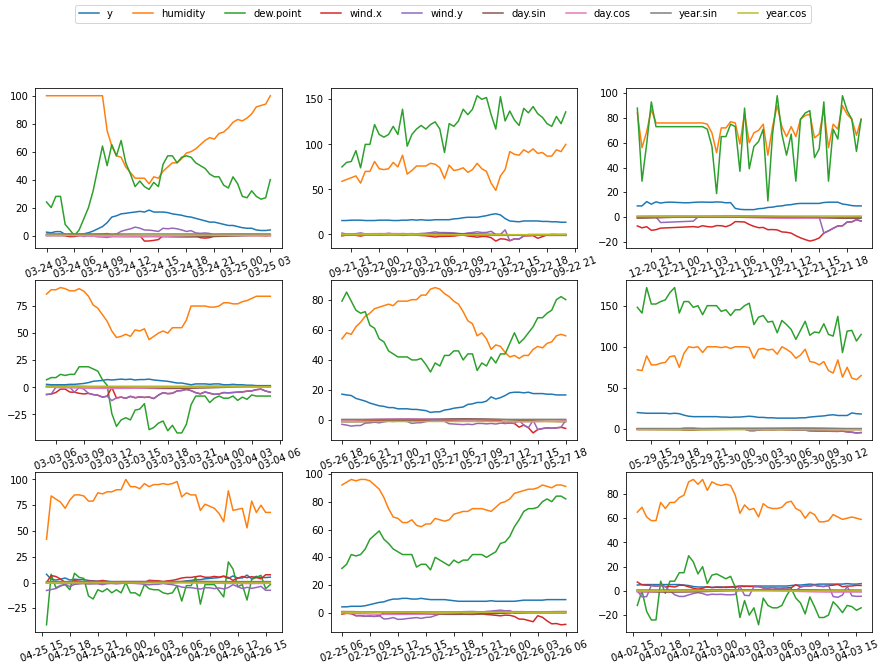

In [2]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetPrepped2021.04.26.csv?raw=true"
else:
    data_loc = "../data/CamMetPrepped2021.04.26.csv"

df = pd.read_csv(data_loc, index_col=['ds'], parse_dates=['ds', 'ds.1'])
df.rename(columns={'ds.1': 'ds'}, inplace = True)
df_orig = df

print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_examples(data, x_var):
    """Plot 9 sets of observations in 3 * 3 matrix"""

    assert len(data) == 9

    cols = [col for col in data[0].columns if col != x_var]

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
        for col in cols:
            axs[i].plot(data[i][x_var], data[i][col])
            axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


cols = ['ds', 'y', 'humidity', 'dew.point', # 'pressure', 
        'wind.x', 'wind.y', 'day.sin', 'day.cos', 'year.sin', 'year.cos']
ex_plots = 9
hour_window = 24
starts = df.sample(n = ex_plots).index
p_data = [df.loc[starts[i]:starts[i] + datetime.timedelta(hours = hour_window), cols] 
          for i in range(ex_plots)]
plot_examples(p_data, 'ds')


<a name="mixup"></a>

### Data augmentation with mixup

Wind velocity vectors were clustered around the 45 degree increments. Data augmentation with the [mixup method](https://arxiv.org/abs/1710.09412) is carried out to counter this clustering.

From the [mixup paper](https://arxiv.org/abs/1710.09412): "mixup trains a neural network on convex combinations of pairs of examples and their labels".

Further details on how I apply the standard mixup technique to time series are included in the Window data section of my [keras_mlp_fcn_resnet_time_series notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb).

Here is a comparison of the improvement in wind velocity sparsity with standard mixup augmentation and a time series specific mixup.

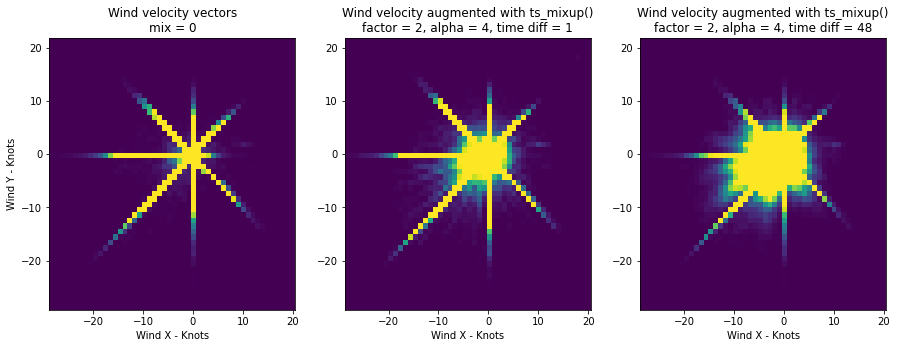

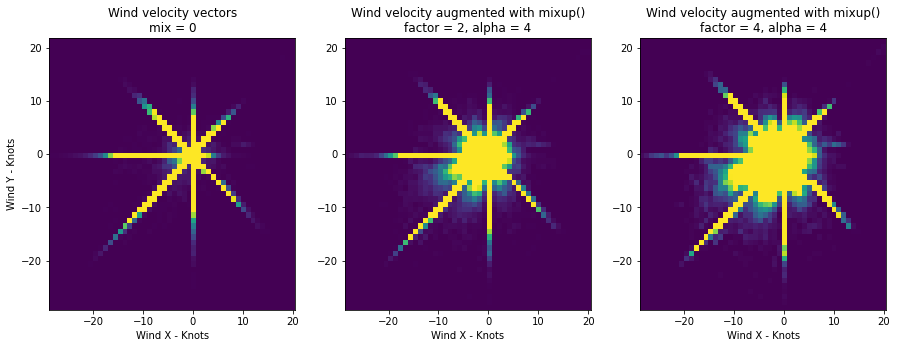

In [3]:
def mixup(data, alpha = 4.0, factor = 1):
    """Augment data with mixup method.

    Standard mixup is applied between randomly chosen observations

    Args:
      data      (pd.DataFrame):    data to run mixup on
      alpha     (float, optional): beta distribution parameter
      factor    (int, optional):   size of mixup dataset to return

    Returns:
      df (pd.DataFrame)

    Notes:
      Duplicates will be removed
      https://arxiv.org/abs/1710.09412
    """
    batch_size = len(data) - 1
    
    data['epoch'] = data.index.view(np.int64) // 10**9
    
    # random sample lambda value from beta distribution
    l   = np.random.beta(alpha, alpha, batch_size * factor)
    X_l = l.reshape(batch_size * factor, 1)
    
    # Get a pair of inputs and outputs
    y1  = data['y'].shift(-1).dropna()
    y1_ = pd.concat([y1] * factor)
    
    y2  = data['y'][0:batch_size]
    y2_ = pd.concat([y2] * factor)

    X1  = data.drop(columns='y', axis=1).shift(-1).dropna()
    X1_ = pd.concat([X1] * factor)
    
    X2  = data.drop(columns='y', axis=1)
    X2  = X2[0:batch_size]
    X2_ = pd.concat([X2] * factor)

    # Perform mixup
    X = X1_ * X_l + X2_ * (1 - X_l)
    y = y1_ * l   + y2_ * (1 - l)    
    
    df = pd.DataFrame(y).join(X)    
    df = data.append(df).sort_values('epoch', ascending = True)
    df = df.drop(columns='epoch', axis=1)
    
    df = df.drop_duplicates(keep = False)
    
    return df


def ts_mixup(data, alpha = 4.0, factor = 1, time_diff = 1):
    """Augment data with time series mixup method.

    Applies mixup technique to two time series separated by time_diff period.

    Args:
      data      (pd.DataFrame):    data to run mixup on
      alpha     (float, optional): beta distribution parameter
      factor    (int, optional):   size of mixup dataset to return
      time_diff (int, optional):   period between data subsets to run mixup on

    Returns:
      df (pd.DataFrame)

    Notes:
      Duplicates will be removed
      https://arxiv.org/abs/1710.09412
      Standard mixup is applied between randomly chosen observations
    """

    batch_size = len(data) - time_diff
    
    # Get a pair of inputs and outputs
    y1 = data['y'].shift(-time_diff).dropna()    
    y2 = data['y'][0:batch_size]

    X1 = data.drop(columns='y', axis=1).shift(-time_diff).dropna()    
    X2 = data.drop(columns='y', axis=1)
    X2 = X2[0:batch_size]

    df = data
    
    for i in range(factor):
      # random sample lambda value from beta distribution
      l   = np.random.beta(alpha, alpha, 1)
      X_l = np.repeat(l, batch_size).reshape(batch_size, 1)

      # Perform mixup  
      X = X1 * X_l + X2 * (1 - X_l)
      y = y1 * l   + y2 * (1 - l)  
    
      df_new = pd.DataFrame(y).join(X)
      idx_len = np.ceil((df.index[-1] - df.index[0]).days / 365.25)
      df_new.index = df_new.index + pd.offsets.DateOffset(years = idx_len)

      df = df.append(df_new).sort_index(ascending = True)
    
    df = df.drop_duplicates(keep = False)
    
    return df


def plot_wind_no_mixup(data, ax):
    """Plot wind vectors without mixup

    Args:
      data      (pd.DataFrame):    wind vector data to plot
      ax        (axes object):     matplotlib axes object for plot    
    """

    plt1 = ax.hist2d(data['wind.x'], data['wind.y'], bins = (50, 50), vmax = 400)
    ax.set_xlabel('Wind X - Knots')
    ax.set_ylabel('Wind Y - Knots')
    ax.set_title('Wind velocity vectors\nmix = 0');


def plot_wind_with_mixup(data, ax, mix_func, mix_factor, mix_alpha = 4, mix_td = 1):
    """Plot wind vectors with mixup

    Args:
      data       (pd.DataFrame):    wind vector data to plot
      ax         (axes object):     matplotlib axes object for plot
      mix_func   (function)         standard or time series mixup function
      mix_factor (int)              size of mixup dataset to return
      mix_alpha  (int, optional)    beta distribution parameter
      mix_td     (int, optional)    period between data subsets to run mixup on
    """
    title = 'Wind velocity augmented with {0:s}()\n'.format(mix_func)

    if mix_func == 'ts_mixup':
        df_mix = ts_mixup(data.loc[:, ['y', 'wind.x', 'wind.y']], 
                          factor = mix_factor,
                          alpha  = mix_alpha, 
                          time_diff = mix_td)
        title += 'factor = {0:d}, alpha = {1:d}, time diff = {2:d}'.format(mix_factor, mix_alpha, mix_td)
    elif mix_func == 'mixup':
        df_mix = mixup(data.loc[:, ['y', 'wind.x', 'wind.y']], 
                       factor = mix_factor,
                       alpha  = mix_alpha)
        title += 'factor = {0:d}, alpha = {1:d}'.format(mix_factor, mix_alpha)

    plt2 = ax.hist2d(df_mix['wind.x'], df_mix['wind.y'], bins = (50, 50), vmax = 400)
    ax.set_xlabel('Wind X - Knots')
    ax.set_title(title);
    # plt.colorbar(plt1, ax = ax3)  # TODO fixme


fig1, (ax11, ax12, ax13) = plt.subplots(1, 3, figsize = (15, 5))
plot_wind_no_mixup(df, ax11)
plot_wind_with_mixup(df, ax12, 'ts_mixup', 2, 4, 1)
plot_wind_with_mixup(df, ax13, 'ts_mixup', 2, 4, 48)

fig2, (ax21, ax22, ax23) = plt.subplots(1, 3, figsize = (15, 5))
plot_wind_no_mixup(df, ax21)
plot_wind_with_mixup(df, ax22, 'mixup', 2)
plot_wind_with_mixup(df, ax23, 'mixup', 4)

Mixup improves the categorical legacy of the wind velocity data. Unfortunately, if outliers are present their influence may be reinforced.  A priori it's difficult to say which mixup variant is preferable.

---

### Split data¶

I use data from 2018 for validation, 2019 for testing and the remaining data for training. These are entirely arbitrary choices. This results in an approximate 84%, 8%, 8% split for the training, validation, and test sets respectively.

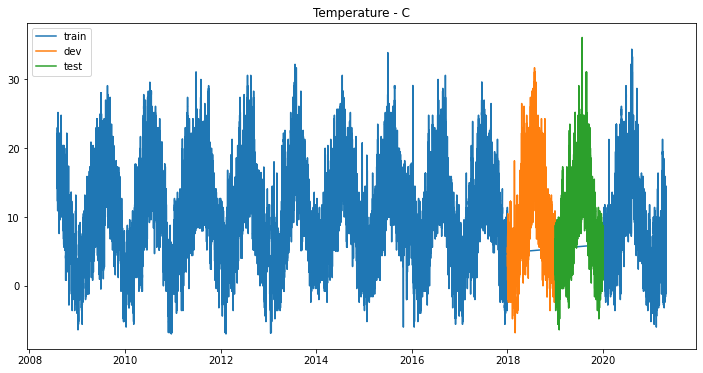

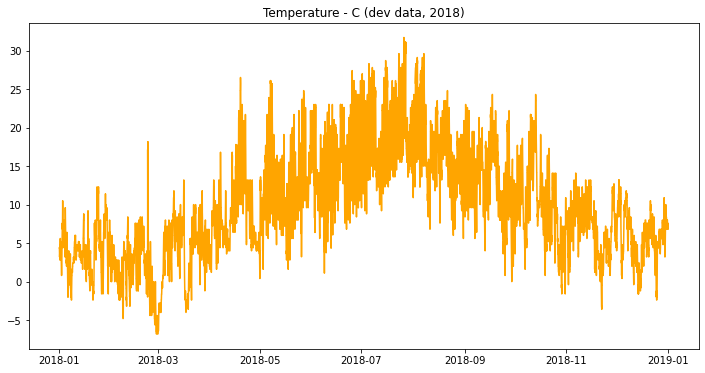

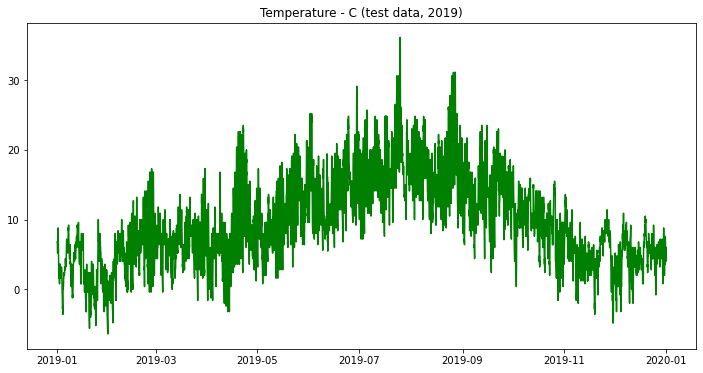

df.drop shape:  (223250, 10)
train shape:    (188210, 10)
valid shape:    (17520, 10)
test shape:     (17520, 10)


In [4]:
# keep_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',
#              'day.sin', 'day.cos', 'year.sin', 'year.cos', 'level', 'season1', 
#              'season2']

df['year'] = df['ds'].dt.year
train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]


plt.figure(figsize = (12, 6))
plt.plot(train_df.ds, train_df.y)
plt.plot(valid_df.ds, valid_df.y)
plt.plot(test_df.ds,  test_df.y)
plt.title('Temperature - C')
plt.legend(['train', 'dev', 'test'])
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(valid_df.ds, valid_df.y, color='orange')
plt.title('Temperature - C (dev data, 2018)')
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(test_df.ds, test_df.y, color='green')
plt.title('Temperature - C (test data, 2019)')
plt.show()


del_cols = ['ds', 'year', 'wind.speed.mean', 'wind.bearing.mean']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols,  axis = 1)
df = df.drop(del_cols, axis = 1)

# ds = {}
models = {}
models['datasets'] = {}
models['datasets']['train'] = train_df
models['datasets']['valid'] = valid_df
models['datasets']['test']  = test_df

print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)


---

### Normalise data

Features should be scaled before neural network training. Arguably, scaling should be done using moving averages to avoid accessing future values.
Instead, simple [standard score](https://en.wikipedia.org/wiki/Standard_score) normalisation will be used.

The [violin plot](https://en.wikipedia.org/wiki/Violin_plot) shows the distribution of features.

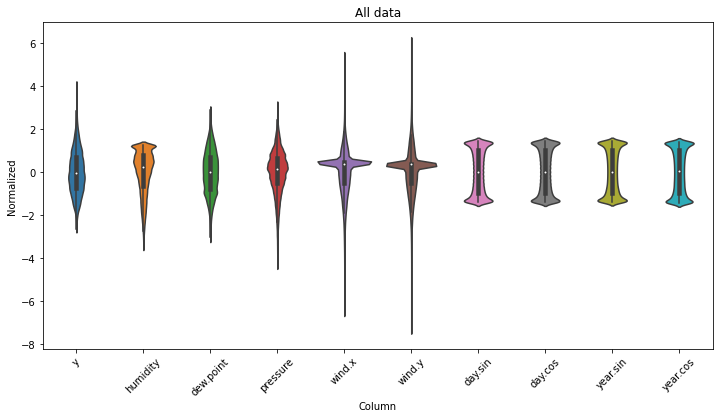

In [5]:
def inv_transform(scaler, data, colName, colNames):
    """An inverse scaler for use in model validation section

    For later use in plot_forecasts, plot_horizon_metrics and check_residuals
    
    See https://stackoverflow.com/a/62170887/100129"""

    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    
    return dummy[colName].values


scaler = StandardScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns] )
valid_df[valid_df.columns] = scaler.transform(valid_df[valid_df.columns] )
test_df[test_df.columns]   = scaler.transform(test_df[test_df.columns] )

df_std = scaler.transform(df)
df_std = pd.DataFrame(df_std)
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(df.keys(), rotation = 45)
ax.set_title('All data');

Some features have long tails but there are no glaring errors.

---

### Window data

Models are trained using sliding windows of samples from the data.

Window parameters to consider for the 
[tf.keras.preprocessing.timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/#timeseries-data-preprocessing) 
function:
 * sequence_length:
   * Length of the output sequences (in number of timesteps), or number of **lag** observations to use
 * sequence_stride:
   * Period between successive output sequences
   * For stride s, output samples start at index data[i], data[i + s], data[i + 2 * s] etc
   * s can include an **offset** and/or 1 or more **steps ahead** to forecast
 * batch_size:
   * Number of samples in each batch
 * shuffle:
   * Shuffle output samples, or use chronological order

Initial values used:
 * sequence_length (aka lags): 24 (corresponds to 12 hours)
 * steps ahead (what to forecast): 
   * 48 - 30 mins, 60 mins ... 1,410 mins and 1,440 mins
 * offset (space between lags and steps ahead): 0
 * batch_size: 16, 32, 64 ...
 * shuffle: True for training data

The `make_dataset` function below generates [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for:
 * Lags, steps-ahead, offset, batch size and shuffle
 * Optionally multiple y columns (Not extensively tested)
 
Stride is used to specify offset + steps-ahead. Offset will be 0 throughout this notebook.

**TODO** Insert figure illustrating lags, offsets and steps-ahead.

`shuffle = True` is used with train data. `shuffle = False` is used with validation and test data so the residuals can be checked for heteroscadicity.

Throughout this notebook I use a shorthand notation to describe lags and strides. For example:
 * 24l_1s_2m is 24 lags, 1 step ahead, 2 times mixup
 * 24l_4s_2m is 24 lags, 4 steps ahead, 2 times mixup

See the `get_model_name` function for details of all abbreviations.

#### Mixup data augmentation

Data augmentation with 
[mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)
by Zhang _et al_ is used to help counter the categorical legacy from the wind bearing variable. Simple 'input mixup' is used as opposed to the batch-based mixup Zhang _et al_ focus on. Input mixup has the advantage that it can be used with non-neural network methods. With current settings these datasets are approximately 3 times larger but this can be varied. Three times more training data is manageable on Colab in terms of both training time and memory usage. Test and validation data is left unmodified.

I apply mixup between consecutive observations in the time series instead of the usual random observations.  Applying mixup between inputs with equal temperature values will not improve performance and will increase run time.

Here are results for a multi-layer perceptron (MLP) with 24 lags, 1 step ahead, 20 epochs training on both less data and less thoroughly cleaned data.

|Augmentation    |	Train rmse |	Train mae |	Valid rmse |	Valid mae |
|----------------|-------------|------------|------------|------------|
|No augmentation |	0.0058     |	0.053     |	0.0054     |	0.052     |
|Input mixup     |	0.0016     |	0.025     |	0.0015     |	0.025     |

See this [commit](https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/93c754d4b1b02e1bd8f827a6f6edc145824f6d23/notebooks/keras_mlp_fcn_resnet_time_series.ipynb) 
for results from other architectures with and without 'input mixup'.

---

Setup functions for creating windowed datasets.

In [43]:
def make_dataset(dataset_params, data):  
    assert dataset_params['stride'] >= dataset_params['steps_ahead']
    y_cols = dataset_params['ycols']

    total_window_size = dataset_params['lags'] + dataset_params['stride']

    data = data.drop(columns='epoch', axis = 1, errors = 'ignore')

    if dataset_params['mix_factor'] != 0:
      if dataset_params['mix_type'] == 'ts':
        data_mix = ts_mixup(data,
                            alpha     = dataset_params['mix_alpha'],
                            factor    = dataset_params['mix_factor'],
                            time_diff = dataset_params['mix_diff'])
      else:
        data_mix = mixup(data,
                         alpha  = dataset_params['mix_alpha'],
                         factor = dataset_params['mix_factor'])
    else:
      data_mix = data

    data_mix = data_mix.drop(columns='epoch', axis = 1, errors = 'ignore')
    data_np  = np.array(data_mix, dtype = np.float32)
        
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
               data    = data_np,
               targets = None,
               sequence_length = total_window_size,
               sequence_stride = 1,
               shuffle    = dataset_params['shuffle'],
               batch_size = dataset_params['bs'])
      
    col_indices = {name: i for i, name in enumerate(data.columns)}
    X_slice = slice(0, dataset_params['lags'])
    y_start = total_window_size - dataset_params['steps_ahead']
    y_slice = slice(y_start, None)
    # print(y_start)

    X1_slice = slice(0, dataset_params['lags'])
    X2_slice = slice(total_window_size, dataset_params['lags'] - 1, -1)


    def split_window(features):
      X = features[:, X_slice, :]
      y = features[:, y_slice, :]

      # X = tf.stack([X[:, :, col_indices[name]] for name in data.columns],
      #              axis = -1)    
      y = tf.stack([y[:, :, col_indices[name]] for name in y_cols], 
                   axis = -1)

      # Slicing doesn't preserve static shape info, so set the shapes manually.
      # This way the `tf.data.Datasets` are easier to inspect.
      X.set_shape([None, dataset_params['lags'],        None])
      y.set_shape([None, dataset_params['steps_ahead'], None])

      return X, y


    def split_window_ed(features):
      X1 = features[:, X1_slice, :]
      X2 = features[:, X2_slice, :]
      y  = features[:,  y_slice, :]

      # X = tf.stack([X[:, :, col_indices[name]] for name in data.columns],
      #              axis = -1)    
      y  = tf.stack([y[:, :, col_indices[name]] for name in y_cols], 
                    axis = -1)
      X2 = tf.stack([X2[:, :, col_indices[name]] for name in y_cols], 
                    axis = -1)

      # Slicing doesn't preserve static shape info, so set the shapes manually.
      # This way the `tf.data.Datasets` are easier to inspect.
      X1.set_shape([None, dataset_params['lags'],        None])
      X2.set_shape([None, dataset_params['steps_ahead'], None])
      y.set_shape( [None, dataset_params['steps_ahead'], None])

      return (X1, X2), y

    if params['model_type'] == 'encdec':
      ds = ds.map(split_window_ed)
      # Extracting past features + deterministic future + labels
      #ds = ds.map(lambda k: ((k[:-24],
      #                        k[-48:, -1:]),
      #                       k[-48:, 0]))
    else:
      ds = ds.map(split_window)

    return ds   


def get_model_name(models, ds_name_params):      
    cols = models['datasets']['train'].loc[:, ds_name_params['xcols']].columns

    suffix = "_{0:d}l_{1:d}s".format(ds_name_params['lags'], 
                                     ds_name_params['steps_ahead'])
    
    suffix += "_{0:d}bs".format(ds_name_params['bs'])

    if ds_name_params['feat_maps'] != 0:
      suffix += "_{0:d}fm".format(ds_name_params['feat_maps'])

    if ds_name_params['filters'] != 0:
      suffix += "_{0:d}f".format(ds_name_params['filters'])

    if ds_name_params['kern_size'] != 0 and len(ds_name_params['kern_size']) == 1:
      suffix += "_{0:d}ks".format(ds_name_params['kern_size'])
      
    if ds_name_params['kern_size'] != 0 and len(ds_name_params['kern_size']) > 1:
      # suffix += "_{0:d}ks".format(ds_name_params['kern_size'])
      # suffix += '_' + '-'.join(ds_name_params['kern_size']) + 'ks'
      suffix += '_' + '-'.join([str(x) for x in ds_name_params['kern_size']]) + 'ks'

    if ds_name_params['mix_factor'] > 0:
      suffix += "_{0:d}m".format(ds_name_params['mix_factor'])
      suffix += "_{0:d}a".format(ds_name_params['mix_alpha'])
      if ds_name_params['mix_type'] == 'ts':
        suffix += "_{0:d}td".format(ds_name_params['mix_diff'])
      if ds_name_params['mix_type'] == 'input':
        suffix += '_im'

    if 'level' in  cols and 'season1' in cols and 'season2' in cols:
      suffix += '_tbats'

    if ds_name_params['drop_out'] != 0.0:
      suffix += "_{0:.2E}do".format(ds_name_params['drop_out'])

    if ds_name_params['kern_reg'] != 0.0:
      suffix += "_{0:.2E}kr".format(ds_name_params['kern_reg'])

    if ds_name_params['recu_reg'] != 0.0:
      suffix += "_{0:.2E}rr".format(ds_name_params['recu_reg'])

    if len(ds_name_params['ycols']) > 1:
      suffix += "_{0:d}y".format(len(ds_name_params['ycols']))

    if ds_name_params['ks_feats'] > 0:
      suffix += "_{0:d}ksf".format(ds_name_params['ks_feats'])

    if ds_name_params['ks_time'] > 0:
      suffix += "_{0:d}kst".format(ds_name_params['ks_time'])

    return ds_name_params['model_type'] + suffix


def make_datasets(models, datasets_params):

    train_data = models['datasets']['train'].loc[:, datasets_params['xcols']]
    valid_data = models['datasets']['valid'].loc[:, datasets_params['xcols']]
    test_data  = models['datasets']['test'].loc[:,  datasets_params['xcols']]

    orig_mix = datasets_params['mix_factor']
    ds_train   = make_dataset(datasets_params, train_data)

    datasets_params['shuffle']    = False
    datasets_params['mix_factor'] = 0
    ds_valid   = make_dataset(datasets_params, valid_data)

    ds_test   = make_dataset(datasets_params, test_data)
    datasets_params['mix_factor'] = orig_mix
    
    return [ds_train, ds_valid, ds_test]


def dataset_sanity_checks(data, name):    
    print(name, "batches: ", data.cardinality().numpy())
    for batch in data.take(1):
        print("\tX (batch_size, time, features): ", batch[0].shape)
        print("\ty (batch_size, time, features): ", batch[1].shape)
        print("\tX[0][0]: ", batch[0][0])
        print("\ty[0][0]: ", batch[1][0])


def plot_dataset_examples(dataset):
    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()
    cols = 0

    for batch in dataset.take(1):
        for i in range(9):
          x = batch[0][i].numpy()
          cols = x.shape[1]
          axs[i].plot(x)

    fig.legend(range(1, cols+1), loc = 'upper center',  ncol = cols+1);


def_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', \
            'day.sin', 'day.cos', 'year.sin', 'year.cos']  # def for default


---

## Encoder Decoder Model Building

Encoder decoder networks ...

Convolutional Neural Networks, or [CNNs](https://en.wikipedia.org/wiki/Convolutional_neural_network), use [convolution](https://en.wikipedia.org/wiki/Convolution) kernels or filters that slide along input features to provide responses known as feature maps.  CNNs assemble hierarchical patterns of increasing complexity starting with smaller and simpler patterns from their filters.

CNNs are frequently applied to analyse visual imagery.  A [spatial convolution](https://keras.io/api/layers/convolution_layers/convolution2d/) can be performed over multi-variate time series observations, and a 1-dimensional [temporal convolution](https://keras.io/api/layers/convolution_layers/convolution1d/) can be applied to vector data.

**TODO** Include basic cncoder decoder diagram

The following are a few points I consider when building these CNN models.

Forecast horizons:
  * next 24 hours - 48 steps ahead

Metrics:
 * mse - mean squared error
   * mse used for loss function to avoid potential problems with infinite values from the square root function
   * rmse - root mean squared error is used for comparison with baselines
   * Huber loss may be worth exploring in the future if outliers remain an issue
 * mae - median absolute error
 * mape - mean absolute percentage error 
   * Not used - mape fails when values, like temperature, become zero

Model enhancements:
 * Teacher forcing?
   * ...
 * Beam search?
   * confidence measure?
     * bootstrap??
     * compare with ensemble of say 5 networks
   * ...
 * mixup
   * input mixup
   * trialed on final model
   * factor - 2
   * alpha - 4 (recommended in the original publication)
   * time series mixup:
     * time diff - 1, ..., 48
       * period between 2 data subsets to run mixup on


Parameters to consider optimising:
 * Learning rate - use LRFinder
 * Optimiser - stick with Adam
 * Shuffle - true for training
 * batch size - 16, 32, 64 ...
 * Number of feature maps
   * 8, 16, 32 ...
 * epochs
   * training shows quite fast convergence so epochs is initially kept quite low (5 or 10)


Model architectures considered:
 * Context vector?
   * ...
 * Basic encoder decoder
   * ...
 * Attention?
   * ...
 * Transformer?
   * ...
 * Gated Residual and Variable Selection Networks model
   * https://keras.io/examples/structured_data/classification_with_grn_and_vsn/
   * ...
 * ...

---


### Learning rate finder

Leslie Smith was one of the first people to work on finding optimal learning rates for deep learning networks in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186). Jeremy Howard from [fast.ai](https://www.fast.ai/) popularised the learning rate finder used here.

Before building any models, I use a modified version of [Pavel Surmenok's Keras learning rate finder](https://github.com/surmenok/keras_lr_finder) to get reasonably close to the optimal learning rate. It's a single small class which I add support for tensorflow datasets to, customise the graphics and add a simple summary function to.

The learning rate finder parameters may benefit from some per-architecture tuning.  It's advisable to find a reasonable start_lr value by trying several values which differ by order of magnitude, i.e. 1e-3, 1e-4, 1e-5 etc.  It's then worthwhile to use the learning rate finder for fine tuning.

Setup learning rate finder class for later usage:

In [7]:
from keras.callbacks import LambdaCallback
import keras.backend as K


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model  = model
        self.losses = []
        self.lrs    = []
        self.best_lr   = 0.001
        self.best_loss = 1e9


    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)


    def find_ds(self, train_ds, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        # N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]
        N = train_ds.cardinality().numpy()

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(train_ds,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)


    def plot_loss(self, axs, sma, n_skip_beginning, n_skip_end, x_scale='log'):
        """
        Plot the loss.

        Parameters:
            n_skip_beginning - number of batches to skip on the left
            n_skip_end - number of batches to skip on the right
        """
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        losses = self.losses[n_skip_beginning:-n_skip_end]
        best_lr = self.get_best_lr(sma, n_skip_beginning, n_skip_end)

        axs[0].set_ylabel("loss")
        axs[0].set_xlabel("learning rate (log scale)")
        axs[0].plot(lrs, losses)
        axs[0].vlines(best_lr, np.min(losses), np.max(losses), linestyles='dashed')
        axs[0].set_xscale(x_scale)


    def plot_loss_change(self, axs, sma, n_skip_beginning, n_skip_end, y_lim=None):
        """
        Plot rate of change of the loss function.

        Parameters:
            axs - subplot axes
            sma - number of batches for simple moving average to smooth out the curve
            n_skip_beginning - number of batches to skip on the left
            n_skip_end - number of batches to skip on the right
            y_lim - limits for the y axis
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        best_lr = self.get_best_lr(sma, n_skip_beginning, n_skip_end)
        y_min, y_max = np.min(derivatives), np.max(derivatives)
        x_min, x_max = np.min(lrs), np.max(lrs)

        axs[1].set_ylabel("rate of loss change")
        axs[1].set_xlabel("learning rate (log scale)")
        axs[1].plot(lrs, derivatives)
        axs[1].vlines(best_lr, y_min, y_max, linestyles='dashed')
        axs[1].hlines(0, x_min, x_max, linestyles='dashed')
        axs[1].set_xscale('log')
        if y_lim == None:
            axs[1].set_ylim([y_min, y_max])
        else:
            axs[1].set_ylim(y_lim)


    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
            
        return derivatives


    def get_best_lr(self, sma, n_skip_beginning, n_skip_end):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        # print("sma:", sma)
        # print("n_skip_beginning:", n_skip_beginning)
        # print("n_skip_end:", n_skip_end)
        # print("best_der_idx:", best_der_idx)
        # print("len(derivatives):", len(derivatives))
        # print("derivatives:", derivatives)
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]


    def summarise_lr(self, train_ds, start_lr, end_lr, batch_size=32, epochs=1, sma=1, n_skip_beginning=200, **kw_fit):
        self.find_ds(train_ds, start_lr, end_lr, batch_size, epochs)
        # print("sma:", sma)
        # print("n_skip_beginning:", n_skip_beginning)
        fig, axs = plt.subplots(1, 2, figsize = (9, 6), tight_layout = True)
        axs = axs.ravel()
        self.plot_loss(axs, sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        self.plot_loss_change(axs, sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        plt.show()

        best_lr = self.get_best_lr(sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        print("best lr:", best_lr, "\n")

        self.best_lr = best_lr


def run_lrf(models, params):
    model_name = get_model_name(models, params)

    train_data = models[model_name]['train']
    model = models[model_name]['model']
    model.compile(loss = 'mse', metrics = ['mae'])
    lrf_inner = LRFinder(model)
    lrf_inner.summarise_lr(train_data, *params['lrf_params'])

    return lrf_inner


lrf_params = [0.000001, 10, 32, 5, 100, 25]



---

Next, define encoder decoder and other network architectures:  

 * `build_conv1d_lstm_model`
 * `build_conv1d_dense_model`
 * `build_multihead_conv1d_lstm_model`
 * `build_multihead_conv1d_dense_model`
 * `build_conv2d_dense_model`
 * `build_stacked_conv2d_model`
 * `build_conv2d_kernel2d_model`
 * `build_inception_model`

In [28]:
def get_io_shapes(data):
    for batch in data.take(1):
        in_shape  = batch[0][0].shape
        out_shape = batch[1][0].shape
        
    return in_shape, out_shape


def build_context_vector_model(models, params):
    model_name = get_model_name(models, params)
    data = models[model_name]['train']
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    feat_maps = params['feat_maps']

    model = Sequential(name = model_name)
    model.add(InputLayer(input_shape = in_shape))

    # encoder
    model.add(LSTM(feat_maps, 
                   activation = 'tanh',
                   input_shape = in_shape))

    # context vector representation 
    model.add(RepeatVector(out_steps))

    # decoder
    model.add(LSTM(feat_maps, 
                   activation = 'tanh',
                   return_sequences = True))
    model.add(TimeDistributed(Dense(feat_maps // 2,
                                    activation = 'relu')))
    model.add(TimeDistributed(Dense(1)))

    return model


def build_basic_encdec_model(models, params):
    model_name = get_model_name(models, params)
    data = models[model_name]['train']
    #in_shape, out_shape = get_io_shapes(data)
    #out_steps = out_shape[0]
    in_shape, out_shape = (24, 10), (48, 1)
    out_steps = 48

    feat_maps = params['feat_maps']
    drop_out  = params['drop_out']
    kern_reg  = params['kern_reg']
    recu_reg  = params['recu_reg']
    filters   = params['filters']
    kern_size = params['kern_size']

    if len(out_shape) == 2:
      out_feats = out_shape[1]
    else:
      out_feats = 1

    #out_steps = 48
    #print(in_shape)
    #print(out_shape)

    # First branch of the net is an lstm which finds an embedding for the past
    # past_inputs = Input(shape = in_shape,
    past_inputs = Input(shape = in_shape,
                        name = 'past_inputs')
    # Encoding the past
    encoder = LSTM(feat_maps, return_state = True)
    encoder_outputs, state_h, state_c = encoder(past_inputs)

    n_deterministic_features = 1
    # future_inputs = Input(shape = (out_steps, n_deterministic_features),
    future_inputs = Input(shape = (out_steps, out_feats),
                          name = 'future_inputs')
    # Combining future inputs with recurrent branch output
    decoder_lstm = LSTM(feat_maps, return_sequences = True)
    x = decoder_lstm(future_inputs, initial_state = [state_h, state_c])

    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    output = Dense(out_steps * out_feats)(x)

    ed_model = tf.keras.models.Model(inputs  = [past_inputs, future_inputs], 
                                     outputs = output,
                                     name    = model_name)

    # Shape [batch, time, features] => [batch, feat_maps]
    #cnnlstm.add(LSTM(feat_maps, 
    #                 return_sequences = False,
    #                 kernel_regularizer = regularizers.l2(kern_reg),
    #                 recurrent_regularizer = regularizers.l2(recu_reg)))
    #
    #cnnlstm.add(Dense(feat_maps,
    #                  activation = 'relu',
    #                  kernel_regularizer = regularizers.l2(kern_reg)))
    #
    #if drop_out != 0.0:
    #  cnnlstm.add(Dropout(drop_out))
    #  # Shape => [batch, out_steps * out_feats]
    #  cnnlstm.add(Dense(out_steps * out_feats,
    #                    kernel_constraint = maxnorm(3)))
    #else:
    #  cnnlstm.add(Dense(out_steps * out_feats))
    #
    #if len(out_shape) == 2:
    #  # Shape => [batch, out_steps, features].
    #  cnnlstm.add(Reshape([out_steps, out_feats]))

    return ed_model


def build_conv1d_lstm_model(models, params):
    model_name = get_model_name(models, params)
    data = models[model_name]['train']
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    feat_maps = params['feat_maps']
    drop_out  = params['drop_out']
    kern_reg  = params['kern_reg']
    recu_reg  = params['recu_reg']
    filters   = params['filters']
    kern_size = params['kern_size']

    if len(out_shape) == 2:
      out_feats = out_shape[1]
    else:
      out_feats = 1

    cnnlstm = Sequential(name = model_name)
    cnnlstm.add(InputLayer(input_shape = in_shape))

    if drop_out != 0.0:
      cnnlstm.add(Dropout(drop_out))

    cnnlstm.add(Conv1D(filters = filters, 
                       activation = 'relu',
                       kernel_size = int(kern_size)))  #, input_shape=(n_timesteps,n_features)))
    cnnlstm.add(MaxPooling1D(pool_size = 2))

    # Shape [batch, time, features] => [batch, feat_maps]
    cnnlstm.add(LSTM(feat_maps, 
                     return_sequences = False,
                     kernel_regularizer = regularizers.l2(kern_reg),
                     recurrent_regularizer = regularizers.l2(recu_reg)))
    
    cnnlstm.add(Dense(feat_maps,
                      activation = 'relu',
                      kernel_regularizer = regularizers.l2(kern_reg)))

    if drop_out != 0.0:
      cnnlstm.add(Dropout(drop_out))
      # Shape => [batch, out_steps * out_feats]
      cnnlstm.add(Dense(out_steps * out_feats,
                        kernel_constraint = maxnorm(3)))
    else:
      cnnlstm.add(Dense(out_steps * out_feats))
    
    if len(out_shape) == 2:
      # Shape => [batch, out_steps, features].
      cnnlstm.add(Reshape([out_steps, out_feats]))

    return cnnlstm


def build_conv1d_dense_model(models, params):
    model_name = get_model_name(models, params)
    data = models[model_name]['train']
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    feat_maps = params['feat_maps']
    drop_out  = params['drop_out']
    kern_reg  = params['kern_reg']
    filters   = params['filters']
    kern_size = params['kern_size']

    if len(out_shape) == 2:
      out_feats = out_shape[1]
    else:
      out_feats = 1

    cnnlstm = Sequential(name = model_name)
    cnnlstm.add(InputLayer(input_shape = in_shape))

    cnnlstm.add(Conv1D(filters = filters, 
                       activation = 'relu',
                       kernel_size = int(kern_size)))  #, input_shape=(n_timesteps,n_features)))
    cnnlstm.add(MaxPooling1D(pool_size = 2))

    cnnlstm.add(Flatten())

    if drop_out != 0.0:
      cnnlstm.add(Dropout(drop_out))

    # Shape [batch, time, features] => [batch, feat_maps]
    cnnlstm.add(Dense(feat_maps, 
                      activation = 'relu',
                      kernel_regularizer = regularizers.l2(kern_reg)))
    
    cnnlstm.add(Dense(int(feat_maps / 2), 
                      activation = 'relu',
                      kernel_regularizer = regularizers.l2(kern_reg)))

    if drop_out != 0.0:
      cnnlstm.add(Dropout(drop_out))
      # Shape => [batch, out_steps * out_feats]
      cnnlstm.add(Dense(out_steps * out_feats,
                        kernel_constraint = maxnorm(3)))
    else:
      cnnlstm.add(Dense(out_steps * out_feats))
    
    if len(out_shape) == 2:
      # Shape => [batch, out_steps, features].
      cnnlstm.add(Reshape([out_steps, out_feats]))

    return cnnlstm


def build_stacked_conv1d_lstm_model(models, params):
    model_name = get_model_name(models, params)
    data = models[model_name]['train']
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    feat_maps = params['feat_maps']
    drop_out  = params['drop_out']
    kern_reg  = params['kern_reg']
    recu_reg  = params['recu_reg']
    filters   = params['filters']
    kern_size = params['kern_size']

    if len(out_shape) == 2:
      out_feats = out_shape[1]
    else:
      out_feats = 1

    cnnlstm = Sequential(name = model_name)
    cnnlstm.add(InputLayer(input_shape = in_shape))

    if drop_out != 0.0:
      cnnlstm.add(Dropout(drop_out))

    cnnlstm.add(Conv1D(filters = filters, 
                       kernel_size = kern_size, 
                       activation = 'relu'))  #, input_shape=(n_timesteps,n_features)))
    cnnlstm.add(MaxPooling1D(pool_size = 2))

    cnnlstm.add(Conv1D(filters = filters, 
                       kernel_size = kern_size + 2, 
                       activation = 'relu'))
    cnnlstm.add(MaxPooling1D(pool_size = 2))

    # Shape [batch, time, features] => [batch, feat_maps]
    cnnlstm.add(LSTM(feat_maps, 
                     return_sequences = True,
                     kernel_regularizer = regularizers.l2(kern_reg),
                     recurrent_regularizer = regularizers.l2(recu_reg)))

    cnnlstm.add(LSTM(int(feat_maps / 2), 
                     return_sequences = False,
                     kernel_regularizer = regularizers.l2(kern_reg),
                     recurrent_regularizer = regularizers.l2(recu_reg)))

    if drop_out != 0.0:
      cnnlstm.add(Dropout(drop_out))
      # Shape => [batch, out_steps * out_feats]
      cnnlstm.add(Dense(out_steps * out_feats,
                        kernel_constraint = maxnorm(3)))
    else:
      cnnlstm.add(Dense(out_steps * out_feats))
    
    if len(out_shape) == 2:
      # Shape => [batch, out_steps, features].
      cnnlstm.add(Reshape([out_steps, out_feats]))

    return cnnlstm


def build_multihead_conv1d_lstm_model(models, params):
    model_name = get_model_name(models, params)
    data = models[model_name]['train']
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    feat_maps = params['feat_maps']
    drop_out  = params['drop_out']
    kern_reg  = params['kern_reg']
    recu_reg  = params['recu_reg']
    filters   = params['filters']
    kern_size = params['kern_size']

    if len(out_shape) == 2:
      out_feats = out_shape[1]
    else:
      out_feats = 1

    # inputs
    inputs1 = Input(shape = in_shape)

    # head 1    
    conv1 = Conv1D(filters = filters, 
                   kernel_size = kern_size * 2 + 1, 
                   activation = 'relu')(inputs1)
    drop1 = Dropout(drop_out)(conv1)
    pool1 = MaxPooling1D(pool_size = 2)(drop1)
    flat1 = Flatten()(pool1)
   
	  # head 2
    conv2 = Conv1D(filters = filters, 
                   kernel_size = kern_size * 3 + 1, 
                   activation = 'relu')(inputs1)
    drop2 = Dropout(drop_out)(conv2)
    pool2 = MaxPooling1D(pool_size = 2)(drop2)
    flat2 = Flatten()(pool2)
   
	  # head 3
    conv3 = Conv1D(filters = filters, 
                   kernel_size = kern_size * 4 + 1, 
                   activation = 'relu')(inputs1)
    drop3 = Dropout(drop_out)(conv3)
    pool3 = MaxPooling1D(pool_size = 2)(drop3)
    flat3 = Flatten()(pool3)
   
	  # merge
    merged = concatenate([flat1, flat2, flat3])
    merged_r = Reshape((-1, 1))(merged)
   
	  # interpretation
    lstm1 = LSTM(feat_maps, 
                 return_sequences = False,
                 kernel_regularizer = regularizers.l2(kern_reg),
                 recurrent_regularizer = regularizers.l2(recu_reg))(merged_r)
    outputs = Dense(out_steps * out_feats)(lstm1)

    model = Model(inputs = inputs1, outputs = outputs, name = model_name)

    return model


def build_multihead_conv1d_dense_model(models, params):
    model_name = get_model_name(models, params)
    data = models[model_name]['train']
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    feat_maps = params['feat_maps']
    drop_out  = params['drop_out']
    filters   = params['filters']
    kern_size = int(params['kern_size'])  # skopt tuple conversion probs

    if len(out_shape) == 2:
      out_feats = out_shape[1]
    else:
      out_feats = 1

    # inputs
    inputs1 = Input(shape = in_shape)

    # head 1    
    conv1 = Conv1D(filters = filters, 
                   kernel_size = kern_size * 2 + 1, 
                   activation = 'relu')(inputs1)
    drop1 = Dropout(drop_out)(conv1)
    pool1 = MaxPooling1D(pool_size = 2)(drop1)
    flat1 = Flatten()(pool1)
   
	  # head 2
    conv2 = Conv1D(filters = filters, 
                   kernel_size = kern_size * 3 + 1, 
                   activation = 'relu')(inputs1)
    drop2 = Dropout(drop_out)(conv2)
    pool2 = MaxPooling1D(pool_size = 2)(drop2)
    flat2 = Flatten()(pool2)
   
	  # head 3
    conv3 = Conv1D(filters = filters, 
                   kernel_size = kern_size * 4 + 1, 
                   activation = 'relu')(inputs1)
    drop3 = Dropout(drop_out)(conv3)
    pool3 = MaxPooling1D(pool_size = 2)(drop3)
    flat3 = Flatten()(pool3)
   
	  # merge
    merged = concatenate([flat1, flat2, flat3])
   
	  # interpretation
    if drop_out != 0.0:
      dense1  = Dense(feat_maps, 
                      activation = 'relu',
                      kernel_constraint = maxnorm(3))(merged)
      dense2  = Dense(int(feat_maps / 2), 
                      activation = 'relu',
                      kernel_constraint = maxnorm(3))(dense1)
      outputs = Dense(out_steps * out_feats,
                      kernel_constraint = maxnorm(3))(dense2)
    else:
      dense1  = Dense(feat_maps, activation = 'relu')(merged)
      dense2  = Dense(int(feat_maps / 2), activation = 'relu')(dense1)
      outputs = Dense(out_steps * out_feats)(dense2)

    model = Model(inputs = inputs1, outputs = outputs, name = model_name)

    return model


def build_conv2d_dense_model(models, params):
    model_name = get_model_name(models, params)
    data = models[model_name]['train']
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    feat_maps = params['feat_maps']
    drop_out  = params['drop_out']
    kern_reg  = params['kern_reg']
    filters   = params['filters']
    kern_size = params['kern_size']

    if len(out_shape) == 2:
      out_feats = out_shape[1]
    else:
      out_feats = 1

    conv2d = Sequential(name = model_name)
    conv2d.add(InputLayer(input_shape = in_shape))

    if drop_out != 0.0:
      conv2d.add(Dropout(drop_out))

    conv2d.add(Reshape((in_shape[0], in_shape[1], 1)))

    conv2d.add(Conv2D(filters = filters, 
                      kernel_size = (1, kern_size),
                      padding = 'same', 
                      activation = 'relu'))  #, input_shape=(n_timesteps,n_features)))
    conv2d.add(Flatten())

    if drop_out != 0.0:
      conv2d.add(Dropout(drop_out))

    conv2d.add(Dense(feat_maps, 
                     activation = 'relu',
                     kernel_regularizer = regularizers.l2(kern_reg)))
    
    conv2d.add(Dense(int(feat_maps / 2), 
                     activation = 'relu',
                     kernel_regularizer = regularizers.l2(kern_reg)))

    if drop_out != 0.0:
      conv2d.add(Dropout(drop_out))
      # Shape => [batch, out_steps * out_feats]
      conv2d.add(Dense(out_steps * out_feats,
                       kernel_constraint = maxnorm(3)))
    else:
      conv2d.add(Dense(out_steps * out_feats))
    
    if len(out_shape) == 2:
      # Shape => [batch, out_steps, features].
      conv2d.add(Reshape([out_steps, out_feats]))

    return conv2d


def build_stacked_conv2d_model(models, params):
    model_name = get_model_name(models, params)
    data = models[model_name]['train']
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    feat_maps = params['feat_maps']
    drop_out  = params['drop_out']
    kern_reg  = params['kern_reg']
    filters   = params['filters']
    ks_feats  = params['ks_feats']
    ks_time   = params['ks_time']

    if len(out_shape) == 2:
      out_feats = out_shape[1]
    else:
      out_feats = 1

    s_conv2d = Sequential(name = model_name)
    s_conv2d.add(InputLayer(input_shape = in_shape))

    if drop_out != 0.0:
      s_conv2d.add(Dropout(drop_out))

    s_conv2d.add(Reshape((in_shape[0], in_shape[1], 1)))

    s_conv2d.add(Conv2D(filters = filters, 
                        kernel_size = (1, ks_feats),
                        padding = 'same', 
                        activation = 'relu'))  #, input_shape=(n_timesteps,n_features)))

    s_conv2d.add(Conv2D(filters = filters, 
                        kernel_size = (ks_time, 1),
                        padding = 'same', 
                        activation = 'relu'))
    s_conv2d.add(Flatten())

    if drop_out != 0.0:
      s_conv2d.add(Dropout(drop_out))

    s_conv2d.add(Dense(feat_maps, 
                       activation = 'relu',
                       kernel_regularizer = regularizers.l2(kern_reg)))
    
    s_conv2d.add(Dense(int(feat_maps / 2), 
                       activation = 'relu',
                       kernel_regularizer = regularizers.l2(kern_reg)))

    if drop_out != 0.0:
      s_conv2d.add(Dropout(drop_out))
      # Shape => [batch, out_steps * out_feats]
      s_conv2d.add(Dense(out_steps * out_feats,
                         kernel_constraint = maxnorm(3)))
    else:
      s_conv2d.add(Dense(out_steps * out_feats))
    
    if len(out_shape) == 2:
      # Shape => [batch, out_steps, features].
      s_conv2d.add(Reshape([out_steps, out_feats]))

    return s_conv2d


def build_conv2d_kernel2d_model(models, params):
    model_name = get_model_name(models, params)
    data = models[model_name]['train']
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    feat_maps = params['feat_maps']
    drop_out  = params['drop_out']
    kern_reg  = params['kern_reg']
    filters   = params['filters']
    ks_feats  = params['ks_feats']
    ks_time   = params['ks_time']

    if len(out_shape) == 2:
      out_feats = out_shape[1]
    else:
      out_feats = 1

    conv2dk2d = Sequential(name = model_name)
    conv2dk2d.add(InputLayer(input_shape = in_shape))

    if drop_out != 0.0:
      conv2dk2d.add(Dropout(drop_out))

    conv2dk2d.add(Reshape((in_shape[0], in_shape[1], 1)))

    conv2dk2d.add(Conv2D(filters = filters, 
                        kernel_size = (ks_time, ks_feats),
                        padding = 'same', 
                        activation = 'relu'))  #, input_shape=(n_timesteps,n_features)))
    conv2dk2d.add(Flatten())

    if drop_out != 0.0:
      conv2dk2d.add(Dropout(drop_out))

    conv2dk2d.add(Dense(feat_maps, 
                       activation = 'relu',
                       kernel_regularizer = regularizers.l2(kern_reg)))
    
    conv2dk2d.add(Dense(int(feat_maps / 2), 
                       activation = 'relu',
                       kernel_regularizer = regularizers.l2(kern_reg)))

    if drop_out != 0.0:
      conv2dk2d.add(Dropout(drop_out))
      # Shape => [batch, out_steps * out_feats]
      conv2dk2d.add(Dense(out_steps * out_feats,
                         kernel_constraint = maxnorm(3)))
    else:
      conv2dk2d.add(Dense(out_steps * out_feats))
    
    if len(out_shape) == 2:
      # Shape => [batch, out_steps, features].
      conv2dk2d.add(Reshape([out_steps, out_feats]))

    return conv2dk2d


def _inception_module(params, input_tensor, stride=1, activation='linear'):

    if params['bottleneck_size'] > 0 and int(input_tensor.shape[-1]) > 1:
        input_inception = keras.layers.Conv1D(filters     = params['bottleneck_size'], 
                                              kernel_size = 1,
                                              padding     = 'same', 
                                              activation  = activation, 
                                              use_bias    = False)(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    # kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]
    kernel_size_s = params['kern_size']

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(keras.layers.Conv1D(filters     = params['filters'], 
                                             kernel_size = kernel_size_s[i],
                                             strides     = stride, 
                                             padding     = 'same', 
                                             activation  = activation, 
                                             use_bias    = False)(input_inception))

    max_pool_1 = keras.layers.MaxPool1D(pool_size = 3, 
                                        strides   = stride, 
                                        padding   = 'same')(input_tensor)

    conv_6 = keras.layers.Conv1D(filters     = params['filters'], 
                                 kernel_size = 1,
                                 padding     = 'same', 
                                 activation  = activation, 
                                 use_bias    = False)(max_pool_1)

    conv_list.append(conv_6)

    x = keras.layers.Concatenate(axis = 2)(conv_list)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation = 'relu')(x)

    return x


def _shortcut_layer(params, input_tensor, out_tensor):
    shortcut_y = keras.layers.Conv1D(filters     = int(out_tensor.shape[-1]), 
                                     kernel_size = 1,
                                     padding     = 'same', 
                                     use_bias    = False)(input_tensor)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    x = keras.layers.Add()([shortcut_y, out_tensor])
    x = keras.layers.Activation('relu')(x)

    return x


def build_inception_model(models, params):
    model_name = get_model_name(models, params)
    data = models[model_name]['train']
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]

    if len(out_shape) == 2:
      out_feats = out_shape[1]
    else:
      out_feats = 1

    input_layer = keras.layers.Input(in_shape)

    x = input_layer
    input_res = input_layer

    for d in range(params['depth']):
        x = _inception_module(params, x)

        if params['use_residual'] and d % 3 == 2:
            x = _shortcut_layer(params, input_res, x)
            input_res = x

    gap_layer = keras.layers.GlobalAveragePooling1D()(x)

    output_layer = keras.layers.Dense(out_steps * out_feats)(gap_layer)

    model = keras.models.Model(inputs  = input_layer, 
                               outputs = output_layer,
                               name    = model_name)

    return model


def get_model(models, params):
    if params['model_type'] == 'conv1d_lstm':
      model = build_conv1d_lstm_model(models, params)
    elif params['model_type'] == 'conv1d_dense':
      model = build_conv1d_dense_model(models, params)
    elif params['model_type'] == 'conv2d_dense':
      model = build_conv2d_dense_model(models, params)
    elif params['model_type'] == 's_conv2d':
      model = build_stacked_conv2d_model(models, params)
    elif params['model_type'] == 'conv2dk2d':
      model = build_conv2d_kernel2d_model(models, params)     
    elif params['model_type'] == 'mh_conv1d_lstm':
      model = build_multihead_conv1d_lstm_model(models, params)
    elif params['model_type'] == 'mh_conv1d_dense':
      model = build_multihead_conv1d_dense_model(models, params)
    elif params['model_type'] == 'incept':
      model = build_inception_model(models, params)
    elif params['model_type'] == 'encdec':
      model = build_basic_encdec_model(models, params)
    elif params['model_type'] == 'context':
      model = build_context_vector_model(models, params)

    return model


def get_default_params(model_type, steps = 48):
    params = {'xcols':        def_cols,
              'ycols':             'y',
              'lags':               48, 
              'steps_ahead':     steps,
              'stride':          steps,
              'shuffle':          True,
              'bs':                 16,
              'model_type': model_type,
              'mix_type':         'ts',
              'mix_alpha':           4,
              'mix_factor':          0,
              'mix_diff':            1,
              'feat_maps':          32,
              'filters':             0,
              'kern_size':           0,
              'ks_feats':            0,
              'ks_time':             0,
              'drop_out':          0.0,
              'kern_reg':          0.0,
              'recu_reg':          0.0,
              'epochs':              5,
              'lrf_params': [0.00001, 10, 32, 5, 100, 25]}

    if params['model_type'] == 'conv1d_lstm':
      params.update({'lags': 144,
                     'bs':    32})
    elif params['model_type'] == 'conv1d_dense':
      params.update({'lags': 144,
                     'bs':    32})
    elif params['model_type'] == 'mh_conv1d_lstm':
      params.update({'lags': 144})
    elif params['model_type'] == 'mh_conv1d_dense':
      params.update({'lags': 144})
    elif params['model_type'] == 'conv2d_dense':
      params.update({'lags': 144})
    elif params['model_type'] == 's_conv2d':
      params.update({'ks_feats': 3,
                     'ks_time':  3})
    elif params['model_type'] == 'conv2dk2d':
      params.update({'ks_feats': 3,
                     'ks_time':  3})
    elif params['model_type'] == 'incept':
      params.update({'depth':            6,
                     'kern_size': [2, 4, 8],
                     'use_residual':  True,
                     'bottleneck_size': 32})
    elif params['model_type'] in ['encdec', 'context']:
      params.update({'lags': 24,
                     'bs':   32})

    return params


def run_model(models, params):
    model_name = get_model_name(models, params)

    h = compile_fit_validate(models, model_name, params)
    plot_history(h, model_name, params['epochs']) 
    print_min_loss(h, model_name)
    
    return h

Specify some utility functions for running, plotting and summarising results:

 * `plot_history`
 * `plot_forecasts`
 * `plot_horizon_metrics`
 * `check_residuals`
 
For running multiple models with specified parameters:
  * `random_search_params` - multiple parameters eg. lags and feature_maps
  * `sweep_param` - single parameter eg. lags

and summarising performance of multiple models:
  * `rank_models`
  * `get_best_models`

Note that I don't use the `random_search_params` function all that much in this notebook because I prefer the scikit-optimize approach outlined in the code cell following this one.

In [9]:
def compile_fit_validate(models, model_name, params, verbose = 2):
    # Reduces variance in results but won't eliminate it :-(
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    model = models[model_name]['model']
    train_data = models[model_name]['train']
    valid_data = models[model_name]['valid']
    
    model.summary()

    # opt = Adam(learning_rate = 0.001)
    opt = Adam(models[model_name]['lrf'].best_lr)

    model.compile(optimizer = opt, loss = 'mse', metrics = ['mae']) 
       
    es = EarlyStopping(monitor = 'val_loss', 
                       mode = 'min', 
                       verbose = 1, 
                       patience = 10,
                       restore_best_weights = True)  # return best model, not last model
    lr = ReduceLROnPlateau(monitor = 'val_loss', 
                           factor = 0.2, 
                           patience = 5, 
                           min_lr = 0.00001)
   
    h = model.fit(train_data, validation_data = valid_data,
                  epochs = params['epochs'], verbose = verbose, callbacks = [es, lr])
    
    return h

    
def plot_history(h, name, epochs = 10):
    fig, axs = plt.subplots(1, 2, figsize = (9, 6), tight_layout = True)
    axs = axs.ravel()

    if 'fm_' in name:
      name = name.replace('fm_', 'fm\n')

    axs[0].plot(h.history['loss'])
    axs[0].plot(h.history['val_loss'])
    axs[0].set_title(name + '\nloss')
    axs[0].set_xticklabels(range(1, epochs + 1))
    axs[0].set_xticks(range(0, epochs))
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'valid'], loc = 'upper right')

    axs[1].plot(h.history['mae'])
    axs[1].plot(h.history['val_mae'])
    axs[1].set_title(name + '\nmae')
    axs[1].set_xticks(range(0, epochs))
    axs[1].set_xticklabels(range(1, epochs + 1))
    axs[1].set_ylabel('mae')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'valid'], loc = 'upper right')
    plt.show()

    return None

    
def print_min_loss(h, name):
    argmin_loss     = np.argmin(np.array(h.history['loss']))
    argmin_val_loss = np.argmin(np.array(h.history['val_loss']))
    min_loss        = h.history['loss'][argmin_loss]
    min_val_loss    = h.history['val_loss'][argmin_val_loss]
    mae             = h.history['mae'][argmin_loss]
    val_mae         = h.history['val_mae'][argmin_val_loss]
    
    txt = "{0:s} {1:s} min loss: {2:f}\tmae: {3:f}\tepoch: {4:d}"
    print(txt.format(name, "train", min_loss,     mae,     argmin_loss + 1))
    print(txt.format(name, "valid", min_val_loss, val_mae, argmin_val_loss + 1))
    print()

    return None


def plot_forecasts(models, model_name, dataset = 'valid', subplots = 3):
    """Plot example forecasts with observations and lagged temperatures.

       First row shows near zero rmse forecasts.
       Second row shows most positive rmse forecasts.
       Third row shows most negative rmse forecasts.
    """

    # get model etc
    model   = models[model_name]['model']
    params  = models[model_name]['params']
    horizon = params['steps_ahead']
    lags    = params['lags']

    assert horizon >= 12
    assert subplots in [3, 4, 5]

    # get data
    if dataset == 'test':
      data = models[model_name]['test']
    elif dataset == 'train':
      data = models[model_name]['train']
    elif dataset == 'valid':
      data = models[model_name]['valid']
    else:
      print("Unknown dataset:", dataset)
      return None

    # make forecast
    preds = model.predict(data)
    preds = preds.reshape((preds.shape[0], preds.shape[1]))
    preds = preds[::horizon]

    obs   = np.concatenate([y for _, y in data], axis = 0)
    long_obs = obs.reshape((obs.shape[0], obs.shape[1]))
    long_obs = long_obs[::horizon]

    res = long_obs - preds  # res for residual
    res_sign = np.sign(-res.mean(axis = 1))

    err = (long_obs - preds) ** 2  # err for error
    err_row_means = err.mean(axis = 1)
    rmse_rows = res_sign * np.sqrt(err_row_means)

    # choose forecasts
    neg_rmse = np.argsort(rmse_rows)[:subplots]
    pos_rmse = np.argsort(-rmse_rows)[:subplots]
    nz_rmse  = np.argsort(np.abs(rmse_rows))[:subplots]  # nz near zero

    plot_idx = np.concatenate((nz_rmse, pos_rmse, neg_rmse))

    # plot forecasts
    fig, axs = plt.subplots(3, subplots, sharex = True, sharey = True, figsize = (15, 10))
    axs = axs.ravel()

    for i in range(3 * subplots):
      lagged_obs = get_lagged_obs(long_obs, plot_idx[i] - 1, lags)
      axs[i].plot(range(-lags + 1, 1),
                  inv_transform(scaler, lagged_obs, 'y', models['datasets']['train'].columns),
                  'blue',
                  label='lagged observations')
      axs[i].plot(range(1, horizon + 1), 
                  inv_transform(scaler, preds[plot_idx[i]],    'y', models['datasets']['train'].columns),
                  'orange',
                  label='forecast')
      axs[i].plot(range(0, horizon), 
                  inv_transform(scaler, long_obs[plot_idx[i]], 'y', models['datasets']['train'].columns),
                  'green',
                  label='observations')
      sub_title = "{0:d} {1:.4f}".format(plot_idx[i], rmse_rows[plot_idx[i]])
      axs[i].title.set_text(sub_title)
    
    fig.suptitle(model_name + " " + dataset + "\nperiod idx, signed rmse")
    fig.text(0.5, 0.04, 'forecast horizon - half hour steps', ha='center')
    fig.text(0.04, 0.5, 'Temperature - $^\circ$C', va='center', rotation='vertical')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show();


def get_lagged_obs(long_obs, plot_idx, lags):
    if long_obs[plot_idx].size < lags:
      lagged_obs = np.flip(long_obs[plot_idx])
    else:
      lagged_obs = long_obs[plot_idx]

    while lagged_obs.size < lags:
      plot_idx -= 1
      lagged_obs = np.concatenate([lagged_obs, np.flip(long_obs[plot_idx])])

    if long_obs[plot_idx].size < lags:
      lagged_obs = np.flip(lagged_obs)

    return lagged_obs[-lags:]


def rmse(obs, preds):
    return np.sqrt(np.mean((obs - preds) ** 2))


def mae(obs, preds):
    return np.median(np.abs(obs - preds))


def plot_horizon_metrics(models, model_name, dataset = 'valid'):

    # get model etc
    model   = models[model_name]['model']
    params  = models[model_name]['params']
    horizon = params['steps_ahead']

    assert horizon >= 12

    # get data
    if dataset == 'test':
      data = models[model_name]['test']
    elif dataset == 'train':
      data = models[model_name]['train']
    elif dataset == 'valid':
      data = models[model_name]['valid']
    else:
      print("Unknown dataset:", dataset)
      return None

    # make forecast
    preds = model.predict(data)
    obs = np.concatenate([y for _, y in data], axis = 0)

    if len(obs.shape) == 3 and len(preds.shape) == 3:
      # multi-step, multi-feature output
      preds = preds[:, :, 0:1]
      preds = preds.reshape((preds.shape[0], preds.shape[1]))
      obs = obs[:, :, 0:1]
      obs = obs.reshape((obs.shape[0], obs.shape[1]))
    elif len(obs.shape) == 3 and len(preds.shape) == 2:
      obs = obs.reshape((obs.shape[0], obs.shape[1]))

    assert preds.shape == obs.shape

    # calculate metrics
    rmse_h, mae_h = np.zeros(horizon), np.zeros(horizon)

    for i in range(horizon):
      t_obs   = inv_transform(scaler, obs[:, i],   'y', models['datasets']['train'].columns)
      t_preds = inv_transform(scaler, preds[:, i], 'y', models['datasets']['train'].columns)
      rmse_h[i] = rmse(t_obs, t_preds)
      mae_h[i]  = mae(t_obs,  t_preds)

    # plot metrics for horizons
    fig, axs = plt.subplots(1, 2, figsize = (14, 7))
    fig.suptitle(model_name + " " + dataset)
    axs = axs.ravel()

    mean_val_lab = model_name + ' mean value'
    axs[0].plot(range(1, horizon+1), rmse_h, label=model_name)
    if dataset == 'test':
      var_rmse = np.array([0.39, 0.52, 0.64, 0.75, 0.86, 0.96, 1.06, 1.15, 1.23, 1.31, 1.38,
       1.45, 1.51, 1.57, 1.63, 1.68, 1.73, 1.77, 1.81, 1.85, 1.89, 1.92,
       1.96, 1.99, 2.02, 2.05, 2.08, 2.1 , 2.13, 2.15, 2.18, 2.2 , 2.22,
       2.24, 2.26, 2.28, 2.3 , 2.31, 2.33, 2.35, 2.36, 2.38, 2.39, 2.4 ,
       2.42, 2.43, 2.44, 2.45])
      axs[0].plot(range(1, horizon+1), var_rmse, label='VAR')
    else:
      axs[0].hlines(np.mean(rmse_h), xmin=1, xmax=horizon, color='yellow', linestyles='dotted', label=mean_val_lab)
    axs[0].set_xlabel("horizon - half hour steps")
    axs[0].set_ylabel("rmse")

    axs[1].plot(range(1, horizon+1), mae_h, label=model_name)
    if dataset == 'test':
      var_mae = np.array([0.39, 0.49, 0.57, 0.66, 0.74, 0.83, 0.91, 0.98, 1.05, 1.12, 1.18,
       1.24, 1.29, 1.34, 1.39, 1.43, 1.47, 1.5 , 1.53, 1.56, 1.59, 1.62,
       1.64, 1.66, 1.68, 1.7 , 1.72, 1.73, 1.75, 1.76, 1.77, 1.78, 1.8 ,
       1.81, 1.82, 1.83, 1.83, 1.84, 1.85, 1.85, 1.86, 1.86, 1.87, 1.87,
       1.88, 1.88, 1.89, 1.89])
      axs[1].plot(range(1, horizon+1), var_mae, label='VAR')
    else:
      axs[1].hlines(np.mean(mae_h), xmin=1, xmax=horizon, color='yellow', linestyles='dotted', label=mean_val_lab)
    axs[1].set_xlabel("horizon - half hour steps")
    axs[1].set_ylabel("mae")
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()


def plot_obs_preds(obs, preds, title):
    plt.figure(figsize = (12, 8))
    plt.subplot(3, 1, 1)
    plt.scatter(x = obs, y = preds)
    y_lim = plt.ylim()
    x_lim = plt.xlim()
    plt.plot(x_lim, y_lim, 'k-', color = 'grey')
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title(title)


def plot_residuals(obs, preds, title):
    plt.subplot(3, 1, 2)
    plt.scatter(x = range(len(obs)), y = (obs - preds))
    plt.axhline(y = 0, color = 'grey')
    plt.xlabel('Position')
    plt.ylabel('Residuals')
    plt.title(title)


def plot_residuals_dist(obs, preds, title):
    data = obs - preds
    plt.subplot(3, 1, 3)
    pd.Series(data).plot(kind = 'density')
    plt.axvline(x = 0, color = 'grey')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def check_residuals(models, model_name, dataset = 'valid'):
    """Plot observations against predictions, residuals and residual distribution
    
    Warning: The full training set will take approx. 5 mins to plot"""

    assert dataset in ['test', 'valid']

    model = models[model_name]
    data  = model[dataset]
    preds = model['model'].predict(data)
    obs   = np.concatenate([y for _, y in data], axis = 0)

    # reshape obs & preds
    label_len = obs.shape[0]
    preds_len = len(preds)
    # print("labels:", label_len)
    # print("preds:",  preds_len)
    # print("preds:",  preds.shape)
    # print("obs:",    obs.shape)
    assert label_len == preds_len

    # print("obs[0]:", obs.shape[0])
    # print("obs[1]:", obs.shape[1])
    preds_long = preds.reshape((obs.shape[0] * obs.shape[1]))
    test_long  = obs.reshape((obs.shape[0] * obs.shape[1]))

    # inverse transform using train mean & sd
    t_preds = inv_transform(scaler, preds_long, 'y', train_df.columns)
    t_obs   = inv_transform(scaler, test_long,  'y', train_df.columns)

    t_rmse = rmse(t_obs, t_preds)  # Need to treat 4 step ahead rmse & mae properly
    t_mae  =  mae(t_obs, t_preds)
    print("t rmse ", model_name, ": ",  t_rmse, sep = '')
    print("t mae ",  model_name, ":  ", t_mae,  sep = '')

    title = 'Inverse transformed data\n' + model_name
    plot_obs_preds(t_obs, t_preds, title)
    plot_residuals(t_obs, t_preds, title)
    plot_residuals_dist(t_obs, t_preds, title)
    print("\n\n")


def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns = dictionary.keys())


def random_search_params(models, params, sweep_values, limit = 5):
    sweep_params = list(sweep_values.keys())
    assert len(sweep_params) > 1

    i = 0
    model_names = []
    sweep_df   = expand_grid(sweep_values)
    sweep_rows = sweep_df.sample(n = limit)

    for sweep_row in sweep_rows.itertuples():
      i += 1
      print("%d of %d" %(i, limit))
      print(sweep_row)
      for idx in sweep_params:
        params[idx] = getattr(sweep_row, idx)

      model_name = get_model_name(models, params)
      model_names.append(model_name)
      models[model_name] = {}
      models[model_name]['params'] = params

      ds_train, ds_valid, ds_test = make_datasets(models, params)
      models[model_name]['train'] = ds_train
      models[model_name]['valid'] = ds_valid
      models[model_name]['test']  = ds_test

      models[model_name]['model'] = get_model(models, params)
      models[model_name]['lrf']   = run_lrf(models, params)
      models[model_name]['history'] = run_model(models, params)

    summarise_history(models, model_names)

    return [models, model_names]


def sweep_param(models, params, sweep_values, verbose=False):
    sweep_params = list(sweep_values.keys())
    sweep_param  = sweep_params[0]
    assert len(sweep_params) == 1
    assert len(sweep_values[sweep_param]) >= 1

    model_names = []

    for sweep_value in sweep_values[sweep_param]:
      # params_copy = {key: value[:] for key, value in params.items()}
      params_copy = {key: value for key, value in params.items()}
      params_copy[sweep_param] = sweep_value

      if verbose == True:
        print(sweep_param, ":", sweep_value)

      model_name = get_model_name(models, params_copy)
      model_names.append(model_name)
      models[model_name] = {}
      models[model_name]['params'] = params_copy

      ds_train, ds_valid, ds_test = make_datasets(models, params_copy)
      models[model_name]['train'] = ds_train
      models[model_name]['valid'] = ds_valid
      models[model_name]['test']  = ds_test

      models[model_name]['model']   = get_model(models, params_copy)
      models[model_name]['lrf']     = run_lrf(models,   params_copy)
      models[model_name]['history'] = run_model(models, params_copy)

    summarise_history(models, model_names)

    return [models, model_names]


def check_fit(h, metric, fit_type, ignore = 1):
    badfit = 0

    h_train = h.history[metric]
    h_valid = h.history['val_' + metric]
    h_len = len(np.array(h_train))

    for i in range(ignore, h_len):
      # Disabling underfitting check for now
      # if ( fit_type == 'over'  and h_valid[i] < h_train[i] ) or \
      #    ( fit_type == 'under' and h_valid[i] > h_train[ignore] ):
      if ( fit_type == 'over'  and h_valid[i] < h_train[i] ):
        badfit += 1

    return round(badfit * 100 / (h_len - ignore), 2)


def get_history_stats(h, metric, ignore = 0):
    stats = {}
    
    stats['mean'] = np.mean(np.array(h.history[metric]))
    stats['std']  = np.std(np.array(h.history[metric]))

    h_argmin = np.argmin(np.array(h.history[metric]))
    h_argmax = np.argmax(np.array(h.history[metric]))
    stats['min'] = h.history[metric][h_argmin]
    stats['max'] = h.history[metric][h_argmax]
    stats['argmin'] = h_argmin

    h_len = len(np.array(h.history[metric]))
    stats['first'] = np.array(h.history[metric])[0]
    stats['last']  = np.array(h.history[metric])[h_len - 1]

    # monotonically decreasing
    stats['monod'] = np.all(np.diff(h.history[metric]) < 0)

    stats['max_eq_first'] = stats['max'] == stats['first']
    stats['min_eq_last']  = stats['min'] == stats['last']

    return stats


def summarise_history(models, model_names):

    for model_name in model_names:
      if model_name == '':
        continue

      model = models[model_name]
      model['perf'] = {}
      mod_perf = model['perf']
      mod_perf['val_loss'] = get_history_stats(model['history'], 'val_loss')
      mod_perf['val_mae']  = get_history_stats(model['history'], 'val_mae')

      mod_perf['loss'], mod_perf['mae'] = {}, {}
      mod_perf['loss']['overfit_pc']  = check_fit(model['history'], 'loss', 'over',  1)
      mod_perf['loss']['underfit_pc'] = check_fit(model['history'], 'loss', 'under', 0)
      mod_perf['mae']['overfit_pc']   = check_fit(model['history'], 'mae',  'over',  1)
      mod_perf['mae']['underfit_pc']  = check_fit(model['history'], 'mae',  'under', 0)

    return None


def get_all_model_names(models):
    names = []

    for name in models.keys():
      if not name in ['datasets']:
        names.append(name)

    return names


def reject_model(mod_perf, strict):
    fit_pc_lim = 0.0
    reject = False

    if mod_perf['loss']['overfit_pc']  > fit_pc_lim or \
       mod_perf['loss']['underfit_pc'] > fit_pc_lim or \
       (strict == True and mod_perf['mae']['overfit_pc']   > fit_pc_lim) or \
       (strict == True and mod_perf['mae']['underfit_pc']  > fit_pc_lim):
      reject = True

    if (strict == True and mod_perf['val_loss']['monod'] == False) or \
       (strict == True and mod_perf['val_mae']['monod']  == False):
      reject = True

    return reject


def get_best_models(models, model_names = None, strict = False):
    best_mse_mod, best_mae_mod = None, None
    low_mse, low_mae = sys.maxsize, sys.maxsize
    
    if model_names == None:
      model_names = get_all_model_names(models)
    
    for model_name in model_names:
      model = models[model_name]

      try:
        mod_perf = model['perf']
      except:
        continue
     
      if reject_model(mod_perf, strict):
        continue

      if mod_perf['val_loss']['min'] < low_mse:
        low_mse = mod_perf['val_loss']['min']
        best_mse_mod = model_name

      if mod_perf['val_mae']['min'] < low_mae:
        low_mae = mod_perf['val_mae']['min']
        best_mae_mod = model_name
    
    return ['low mse ' + str(best_mse_mod), round(low_mse, 5), 
            'low mae ' + str(best_mae_mod), round(low_mae, 5)]


def plot_perf_boxplot(models, metric, model_names = None, strict = False):
    stats = []

    assert metric in ['val_loss', 'val_mae']

    if model_names == None:
      model_names = get_all_model_names(models)
      title = 'All models'
    else:
      # title = [k for k, v in locals().items() if v == 'model_names']
      title = str(len(model_names)) + ' models'
    
    title += ' - strict=' + str(strict)
    
    for model_name in model_names:
      try:
        mod_perf = models[model_name]['perf']
      except:
        continue
     
      if reject_model(mod_perf, strict):
        continue

      stats.append(mod_perf[metric]['min'])

    assert len(stats) > 2

    fig1, ax1 = plt.subplots()
    ax1.set_title(title + ' ' + metric)
    ax1.boxplot(stats, labels=['']);


def rank_models(models, metric, model_names = None, strict = False, limit = 5):
    stats = {}

    assert metric in ['val_loss', 'val_mae']

    if model_names == None:
      model_names = get_all_model_names(models)
    
    for model_name in model_names:
      try:
        mod_perf = models[model_name]['perf']
      except:
        continue
     
      if reject_model(mod_perf, strict):
        continue

      stats[model_name] = round(mod_perf[metric]['min'], 5)

    return sorted(stats.items(), key=lambda item: item[1])[:limit]
    # return [dict(sorted(stats.items(), key=lambda item: item[1]))][:limit]


def keep_key(d, k):
  """ models = keep_key(models, 'datasets') """
  return {k: d[k]}

### Bayesian hyperparameter optimization

I've used the [BayesianOptimization](https://github.com/fmfn/BayesianOptimization) package in the past to optimise [time series forecasts](https://github.com/makeyourownmaker/BayesianProphet).  It works well  but doesn't have any plotting functions.  It should be possible to spot irrelevant hyperparameters with the [scikit-optimize plot_objective](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_objective.html) function even if the underlying gaussian processes are approximations.

The `model_fitness_1s` example function is passed to `gp_minimize` from [scikit-optimize](https://scikit-optimize.github.io/stable/).  The `model_fitness_1s` function should be seen as an implementation example which will be customised later for particular network architectures and parameters to optimise.

In [10]:
# !pip freeze

!pip install scikit-optimize

import skopt
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence, plot_objective, plot_evaluations, \
                        plot_gaussian_process
from skopt.utils import use_named_args

print("\nskopt version:", skopt.__version__)


dim_lags = Integer(low = 4,  high = 48, name = 'lags')
dim_bs   = Integer(low = 16, high = 32, name = 'bs')
dim_fm   = Integer(low = 16, high = 32, name = 'feat_maps')
dim_drop_out = Real(low = 1e-3, high = 5e-1, prior = 'log-uniform', name = 'drop_out')

bo_dims_1s = [dim_lags,
              dim_bs,
              dim_fm,
              dim_drop_out]


def create_model(params):

    model_name = get_model_name(models, params)
    models[model_name] = {}
    models[model_name]['params'] = params

    ds_train, ds_valid, ds_test = make_datasets(models, params)
    models[model_name]['train'] = ds_train
    models[model_name]['valid'] = ds_valid
    models[model_name]['test']  = ds_test

    models[model_name]['model'] = get_model(models, params)
    models[model_name]['lrf']   = run_lrf(models, params)

    return models[model_name]['model']


def get_bo_mse(params, **dims):

    params.update(**dims)

    for k, v in dims.items():
        print(k, v)
    
    model_names = ['']
    model_name = get_model_name(models, params)
    model_names.append(model_name)

    # skopt will re-evaluate the same point, even when gp_minimize(..., noise = 1e-10) is set
    # Some problems are noisy but regardless is bad default behaviour!
    # DO NOT rebuild the model 
    if not model_name in models:
      model = create_model(params)
      models[model_name]['history'] = run_model(models, params)
      summarise_history(models, model_names)

    print(model_name)
    bo_mse = models[model_name]['perf']['val_loss']['min']
     
    if reject_model(models[model_name]['perf'], strict = False):
      print("WARN: bad model", model_name)
      BAD_MODEL_PENALTY = 1
      bo_mse *= BAD_MODEL_PENALTY  # bad models get (arbitrarly) "higher" values

    return bo_mse


@use_named_args(dimensions = bo_dims_1s)
def model_fitness_1s(**dims):
    """This function is for illustrative purposes.
       The params values must be adapted for each optimisation task.
       Here default parameters for a single step-ahead stacked LSTM are used.
    """

    params = get_default_params('s_lstm', 1)

    return get_bo_mse(params, **dims)


def run_bo_search(bayes_opt, bo_id):

    # noise, limit but unfortunately not prevent re-evaluating the same point
    noise_level = 1e-10

    bo_search_results = gp_minimize(func = bayes_opt[bo_id]['fitness_func'],
                                    dimensions = bayes_opt[bo_id]['dims'],
                                    x0 = bayes_opt[bo_id]['init_dims'],
                                    n_calls = bayes_opt[bo_id]['calls'],
                                    acq_func = 'EI',
                                    noise = noise_level, 
                                    verbose = True,
                                    random_state = 42)

    print()
    print(bo_search_results.x)
    print(bo_search_results.fun)
    print()

    plot_convergence(bo_search_results)

    plot_objective(result   = bo_search_results)
    plot_evaluations(result = bo_search_results)

    plot_bo_func_vals_dist(bo_search_results.func_vals, bo_id)

    return bo_search_results


def plot_bo_func_vals_dist(data, bo_results_id):
    """Plot skopt function values distribution using swarmplot and boxplot"""

    title = bo_results_id + ' gp_minimize function values - mse'

    fig1, ax1 = plt.subplots()
    ax1 = sns.swarmplot(y = data)
    ax1 = sns.boxplot(y = data,
                      showcaps = False, 
                      boxprops = {'facecolor':'None', 'linewidth':1},
                      showfliers = False).set_title(title)
    plt.show()


hpo = {}  # hyperparameter optimisation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 6.3 MB/s 

skopt version: 0.9.0




---

### Conv1D-LSTM

A one-dimensional Convolutional Neural Network (CNN) is a model that has a convolutional hidden layer that operates over a 1D sequence.  The CNN layers are commonly followed by a pooling layer which distills the output of the CNN layer to the most important parts.

Code for this architecture is in the `build_basic_encdec_model` function.

Briefly, the architecture is (omitting dropout and regularisation):
 * Conv1D()
 * LSTM(return_sequences=False)
 * Dense(activation='relu')
 * Dense()

Hardcoded parameters:
 * I've somewhat arbitrarily chosen to use a batch size of 32

Optimise:

 * lags
 * feat_maps - LSTM feature maps
 * Conv1D() filters
 * Conv1D() kern_size

Iteration No: 1 started. Evaluating function at provided point.
lags 24
feat_maps 32
Epoch 1/5
5880/5880 [==============================] - 16s 1ms/step - loss: 12154.6338 - mae: 4.6096


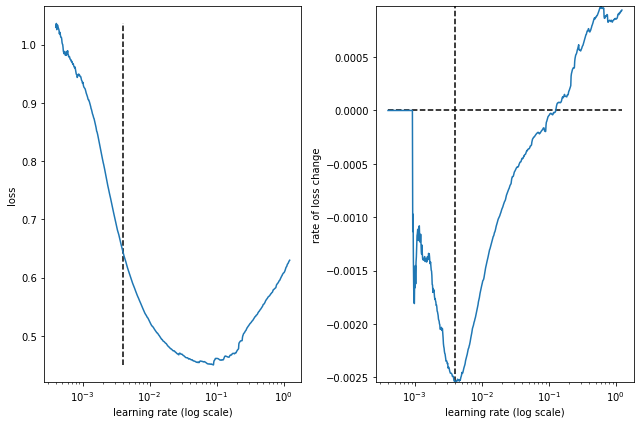

best lr: 0.0040221326 

Model: "encdec_24l_48s_32bs_32fm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 past_inputs (InputLayer)       [(None, 24, 10)]     0           []                               
                                                                                                  
 future_inputs (InputLayer)     [(None, 48, 1)]      0           []                               
                                                                                                  
 lstm_22 (LSTM)                 [(None, 32),         5504        ['past_inputs[0][0]']            
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                   

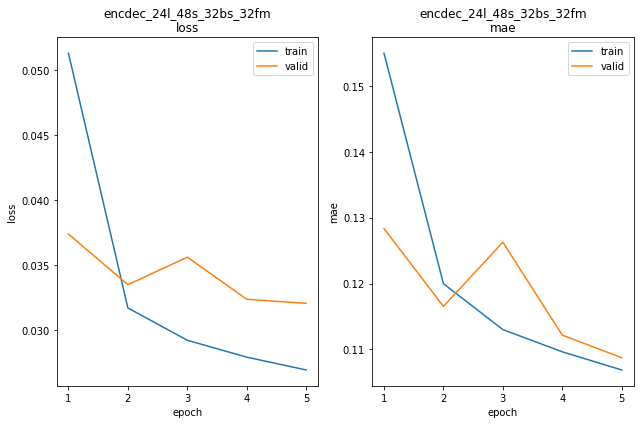

encdec_24l_48s_32bs_32fm train min loss: 0.026920	mae: 0.106873	epoch: 5
encdec_24l_48s_32bs_32fm valid min loss: 0.032049	mae: 0.108731	epoch: 5

encdec_24l_48s_32bs_32fm
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 337.1670
Function value obtained: 0.0320
Current minimum: 0.0320
Iteration No: 2 started. Evaluating function at random point.
lags 120
feat_maps 18
Epoch 1/5


ValueError: ignored

In [44]:
#%%time

# zzz
models = keep_key(models, 'datasets')

results_id = 'encdec_48s'
hpo[results_id] = {}

dim_lags      = Integer(low = 24, high = 144, name = 'lags')
dim_feat_maps = Integer(low =  8, high =  64, name = 'feat_maps')

hpo[results_id]['dims'] = [dim_lags,
                           dim_feat_maps]
hpo[results_id]['init_dims'] = [24, 32]
hpo[results_id]['calls']     = 20


@use_named_args(dimensions = hpo[results_id]['dims'])
def model_fitness(**dims):
    params = get_default_params('encdec')
    params.update({'lrf_params': [0.0003, 10, 32, 5, 100, 25]})

    return get_bo_mse(params, **dims)


hpo[results_id]['fitness_func'] = model_fitness
hpo[results_id]['results']      = run_bo_search(hpo, results_id)


get_best_models(models)

display(rank_models(models, 'val_loss', strict = True, limit = 5))
display(rank_models(models, 'val_mae',  strict = True, limit = 5))


Results for optimised Conv1D-LSTM 48 steps-ahead forecast models after 5 epochs:

| CNN model | params                                     | mse     | mae     |
|-----------|--------------------------------------------|---------|---------|
|Conv1D-LSTM| lags=30,feat_maps=27,filters=63,kern_size=7| 0.12481 | 0.26295 |

Best model:
 * conv1d_lstm_30l_48s_32bs_27fm_63f_7ks 

This is not quite as good as the best pure LSTM architectures but run time is lower.

It's difficult to draw useful conclusions from the Gaussian process plots.

It's clear from some of the learning rate finder curves that start_lr and/or end_lr could be further refined.  Start_lr may be a little low but results seem OK.

As with all of the skopt runs, it would benefit from running for more iterations and probably more learning rate tuning.


---


### Conv1D-Dense


Code for this architecture is in the `build_conv1d_dense_model` function.

Briefly, the architecture is (omitting dropout and regularisation):
 * Conv1D()
 * MaxPooling1D()
 * Flatten()
 * Dense(activation='relu')
 * Dense(activation='relu')
 * Dense()

Hardcoded parameters:
 * I've somewhat arbitrarily chosen to use a batch size of 32.

Optimise:

 * lags
 * feat_maps - LSTM feature maps
 * Conv1D() filters
 * Conv1D() kern_size

Results of the optimised mixup model for 48 steps-ahead forecast  after 5 epochs:

| CNN model | params                                     | mse     | mae     |
|-----------|--------------------------------------------|---------|---------|
|Conv2D Kern2D| lags=28,ks_feats=1,ks_time=7             | 0.11686 | 0.25261 |
|Conv2D Kern2D mix_diff| mix_diff=4                      | 0.11952 | 0.25462 |

Best model:
 * conv2dk2d_28l_48s_16bs_448fm_64f_2m_4a_4td_1ksf_7kst

The minimal mse value, 0.11952, is higher than the Conv2D Kern2D value without any mixup.  Perhaps this lack of improvement, compared to the earlier mentioned MLP-mixup results, may be due to different architectures (MLP versus Conv2D), different number of lagged variables (24 versus 28), different number of forecasts steps (1 versus 48), different number of training epochs (20 versus 5).

From the Gaussian process plots we can infer:
 * mix_diff - lower is better
   * the minimum mse values occurs at mix_diff = 4
     * there may be a periodic structure to the distribution of mse values
     * with possible maxima around 12 and 36
     * and possible minima around 24 and 48
     * there was an unexpectedly low mse value at 32

Only 20 skopt calls were used instead of the usual 60.  Given more compute resources it may be justifiable to optimise mix_diff with lags for 20 epochs.

It's clear from some of the learning rate finder curves that start_lr and/or end_lr could be further refined.  There are signs of overfitting; start_lr may be a little high.

As with all of the skopt runs, it would benefit from running for more iterations and probably more learning rate tuning.

---

### Comparison with baselines

Finally, we can compare the best performing encoder decoder model against the best baseline method.  The VAR (Vector Auto-Regression) model from the [baselines notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) was the best performing baseline.

The best encoder decoder model, after 5 training epochs, was conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst.  Here I train the same model for 20 epochs.

Some points to note regarding the `plot_forecasts` diagnostic plot:
 * on validation data not test data
 * `plot_forecasts`
   * plot example forecasts with observations and lagged temperatures
      * first row shows examples of best near zero rmse forecasts
      * second row shows examples of worst positive rmse forecasts
      * third row shows examples of worst negative rmse forecasts
      * lagged observations are negative
      * the day of the year the forecast begins in and the rmse value is displayed above each sub-plot

epochs : 20
Epoch 1/5
11759/11759 [==============================] - 13s 1ms/step - loss: 30942466.0000 - mae: 142.3176


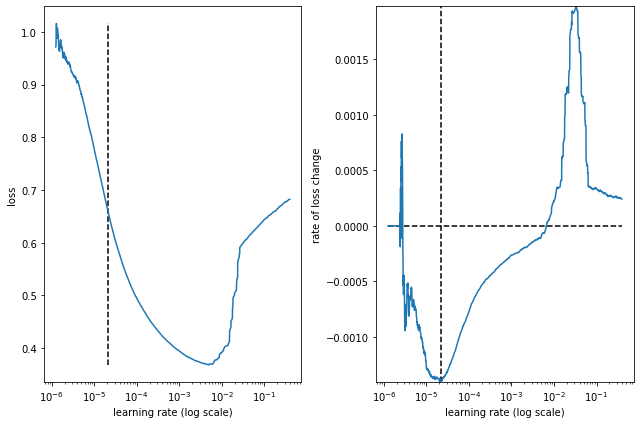

best lr: 2.1549979e-05 

Model: "conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 28, 10, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 10, 64)        512       
                                                                 
 flatten_2 (Flatten)         (None, 17920)             0         
                                                                 
 dense_6 (Dense)             (None, 448)               8028608   
                                                                 
 dense_7 (Dense)             (None, 224)               100576    
                                                                 
 dense_8 (Dense)             (None, 48)                10800     
                                                                 

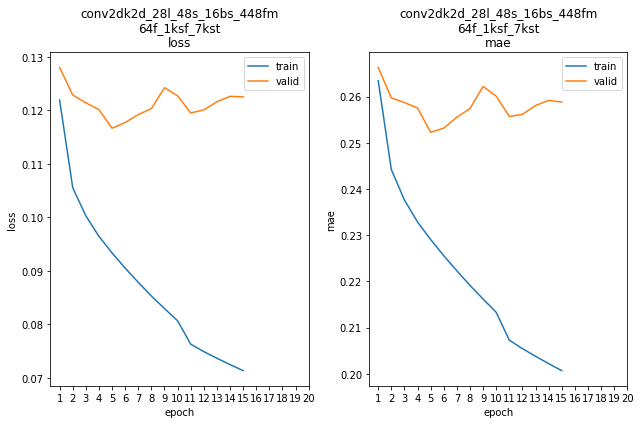

conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst train min loss: 0.071346	mae: 0.200707	epoch: 15
conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst valid min loss: 0.116655	mae: 0.252278	epoch: 5



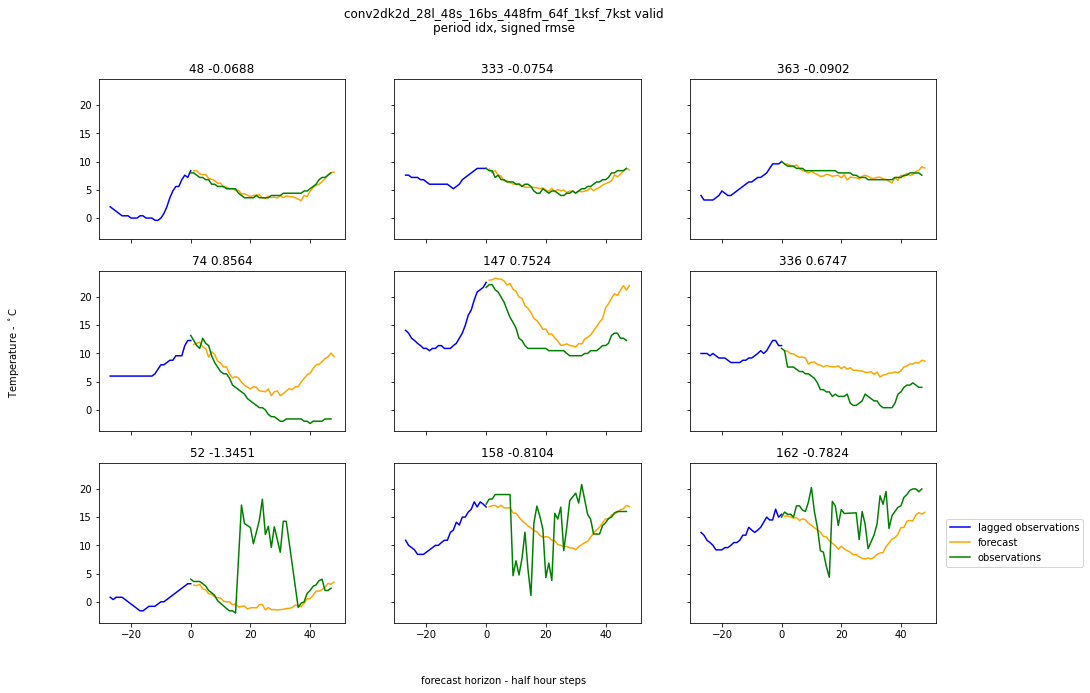

CPU times: user 20min 42s, sys: 3min 50s, total: 24min 32s
Wall time: 20min


In [ ]:
%%time


params = get_default_params('conv2dk2d')
params.update({'feat_maps':  448,
               'filters':     64,
               'lags':        28,
               'ks_feats':     1,
               'ks_time':      7,
               'lrf_params': [0.000001, 10, 32, 5, 100, 25]})
sweep_values = {'epochs': [20]}
models, epochs_model_names = sweep_param(models, params, sweep_values, verbose=True)

model_name = epochs_model_names[0]
plot_forecasts(models, model_name)

Results of the conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst model for 48 steps-ahead forecast after 20 epochs:

| CNN model             | params                         | mse     | mae     |
|-----------------------|--------------------------------|---------|---------|
|Conv2D Kern2D epochs= 5| lags=28, ks_feats=1, ks_time=7 | 0.11686 | 0.25261 |
|Conv2D Kern2D epochs=20| lags=28, ks_feats=1, ks_time=7 | 0.11665 | 0.25228 |

The model stopped training early after 15 epochs.  There was a marginal improvement in mse and mae.  As before, the minimal mse value was acheived at the 4th epoch.  The training plot shows some over-fitting.  Arguably, I should try the next best model but I doubt this will improve results by much.

Diagnostic plot summary:
 * once again, on validation data not test data
 * `plot_forecasts`
   * third row shows three highly suspect looking sets of observations for worst negative rmse forecast examples
   * clearly some remaining problem in the observations

---


Next, I plot the best Conv2D kernel 2D and VAR model rmse and mae values for forecast horizons up to 48 (24 hours, each horizon step is equivalent to 30 minutes).  This plot plus the two others are for forecasts on the previously unused 2019 "test" data.  This is different from the 2018 "validation" data used elsewhere in this notebook.

Some points to note regarding diagnostic plots:
 * once again, on test data not validation data
 * `plot_horizon_metrics`
   * plot rmse and mae values for each individual step-ahead
 * `check_residuals`
   * observations against predictions
   * residuals over time
   * residual distribution
 * `plot_forecasts`
   * see sub-section immediately above for notable points

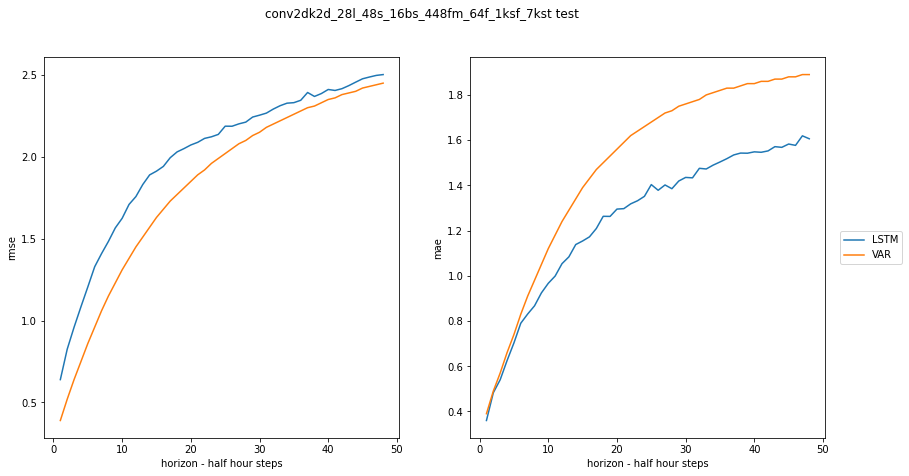

t rmse conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst: 2.057958616855633
t mae conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst:  1.179860027368246


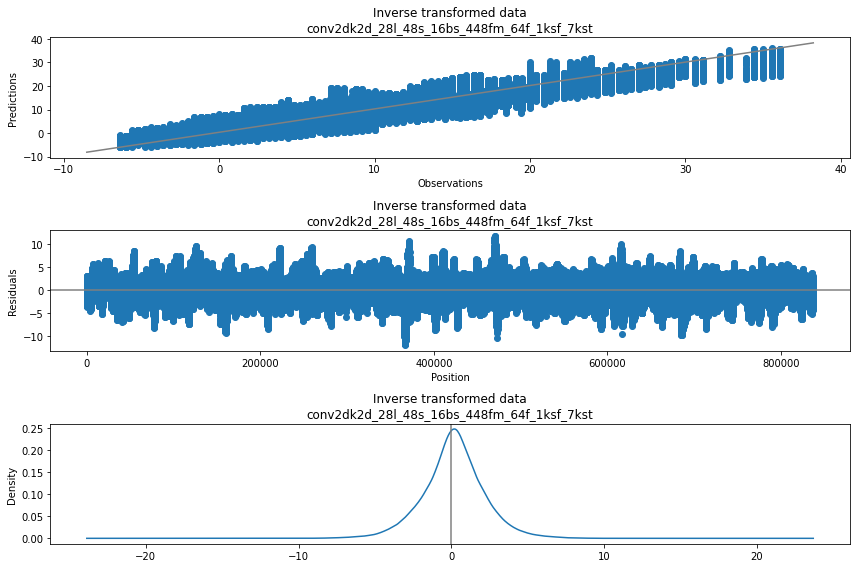

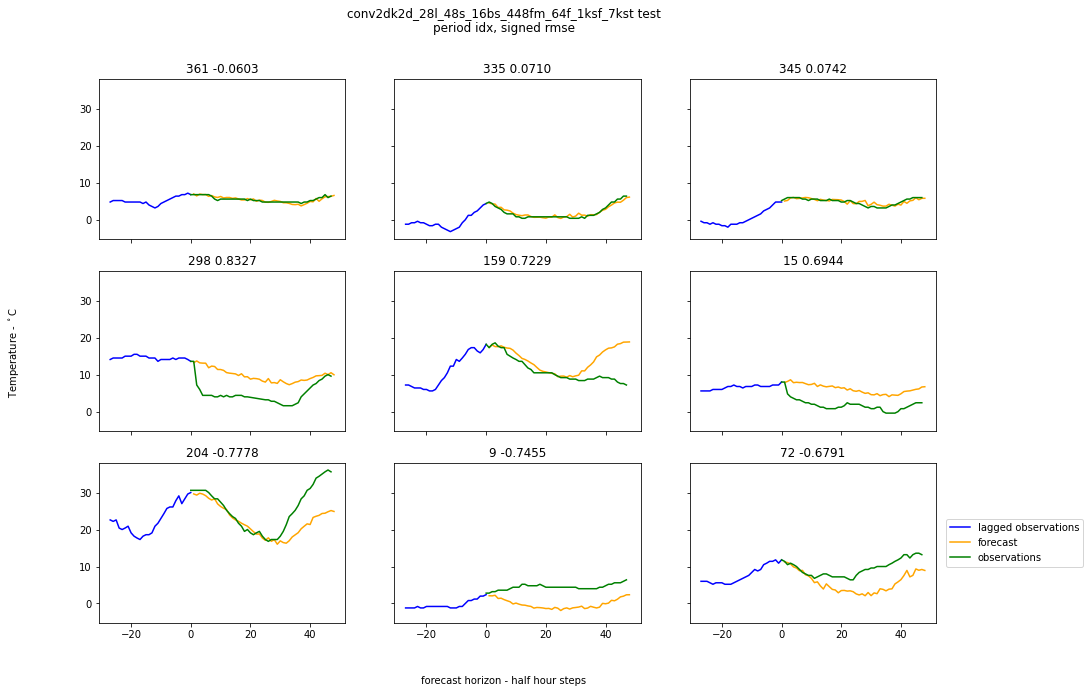

In [ ]:
ds = 'test'
best_mod = 'conv2dk2d_28l_48s_16bs_448fm_64f_1ksf_7kst'

plot_horizon_metrics(models, best_mod, dataset = ds)
check_residuals(models, best_mod, dataset = ds)
plot_forecasts(models, best_mod, dataset = ds)

Broadly speaking, these results are very similar to the results from the [best LSTM model](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb).


Diagnostic plots summary:
 * once again, these plots use test data not validation data
 * `plot_horizon_metrics`
   * initially, these results look quite contradictory
   * the rmse plot indicates better forecasts for the VAR method (in orange)
   * the mae plot indicates better forecasts for the Conv2D kernel 2D method (in blue, mis-labelled as LSTM)
 * `check_residuals`
   * the observations against predictions plot indicates
     * predictions are too high at cold temperatures (below 0 C) 
     * predictions are too low at hot temperatures (above 25 C)
   * residuals over time
     * no obvious heteroscadicity
     * no obvious periodicity
       * surprising given observations against predictions plot
   * residual distribution appears to be approximately normal (slightly right-skewed)
     * no obvious sign of fat tails
 * `plot_forecasts`
   * notable lack of noisy observations for the large positive and negative rmse examples

The median absolute error (mae) is less sensitive to outliers compared to the root mean squared error (rmse) metric.

Therefore, the rmse and mae plot difference may be due to the presence of outliers. I have maintained from the start that this data set is quite noisy, and attempts to correct these problems may have unintensionally introduced new issues.

Transformed mean values across the 48 step horizon:
 * rmse of 2.05796
 * mae of 1.17986

---


## Conclusion

The best results from the Conv2D kernel 2D are very similar to the results from the [best LSTM model](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb).

The conclusion is separated into the following sections:
 * What worked
 * What didn't work
 * Future work

What worked:
 * Conv1D followed by
   * LSTM layer
     * simple and reasonably effective set of models
   * 2 Dense layers
     * simple and reasonably effective set of models
 * Multi-head
   * 3 independent Conv1D "heads" with different kernel sizes
     * did not improve on single head Conv1D models
 * Conv2D
   * very high number of parameters
   * single Conv2D layer
     * feature extraction kernel
       * probably the best performing set of models
   * 2 stacked Conv2D layers
     * first feature extraction kernel
     * second temporal extraction kernel
     * reasonable results but didn't improve on single Conv2D layer
 * Inception-style
   * 6 inception modules with residual connections at the 3rd and 6th modules
     * only partially optimised but gave acceptible results
     * may benefit from larger kernel sizes - 2, 8, 16 instead of 2, 4, 8
     * slow to train
 * skopt Bayesian hyperparameter optimisation
   * summary from Conv2D models
     * lags - lower is better
       * some models showed periodicity
       * with secondary minima around 48 and 96 steps
     * feature maps - higher is better
     * filters - higher is better
     * kernel size
       * feature extraction - lower is better
       * temporal extraction - higher is better
   * more optimisation iterations are probably justifiable
   * exact order to optimise parameters in remains unclear
     * feature selection
     * lags?
     * architecture selection
     * learning rate
     * batch size
     * lags?
     * the rest!
     * regularisation parameters _later_ on (best performing models only)

What didn't work:
 * Conv2D
   * single Conv2D layer
     * combined feature-temporal extraction kernel
       * the training plot shows some over-fitting
       * it is recommended to extend training epochs from 5 to 10 to avoid this
 * Dealing with outliers remains problematic
   * further data cleaning would be beneficial
     * particularly labeling the interpolation, imputation etc missing data cases
 * Learning rate finder has issues
   * tuning the start learning rate parameter defeats the purpose of the method
     * this tuning could be replaced with multiple learning rate finder runs
     * using start learning rate parameter increasing in order of magnitude: 1e-5, 1e-4, etc
       * this was performed manually on a per-architecture basis but would benefit from automation
     * choose start learning rate that minimises loss value
     * straight-forward change but will increase running time
 * Mixup
   * the minimal mse value was higher than the Conv2D kernel 2D value without any mixup 
   * perhaps this lack of improvement may be due to the particular Conv2D kernel 2D model overfitting

Future work:
 * Further optimise model and data parameters
   * check robust regression loss functions
     * [Huber loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber)
     * less sensitive to outliers than the squared error loss
   * lags
     * 1-24 plus zero or more of {48, 96, 144, 192, 240, 288, 336}
   * seasonal components
     * one-hot encoded month variables
     * the [Short Time Fourier Transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) may be a good option for modeling the daily seasonality
       * it is available in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html)
   * batch mixup
     * probably only time series mixup
   * apply regularisation to best performing model
     * dropout, L2, time series mixup
 * Additional architectures to examine
   * Conv2D inception model
     * inception-style models are worth exploring further despite the relatively high mse value of the Conv1D-based model due to the incomplete optimisation. 
     * runtime may be an issue

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

IPython version:
5.5.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


name,version
tensorflow,2.8.2+zzzcolab20220527125636
seaborn,0.11.2
scikit-learn,1.0.2
pandas,1.3.5
numpy,1.21.6
matplotlib,3.2.2
keras,2.8.0


In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.178
BogoMIPS:            4000.35
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

In [ ]:
!date

Sat Jun 18 14:10:54 UTC 2022


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "encoder_decoder.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}